In [106]:
import sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')

import gw150814_simulator as gs
# import module

import torch
import numpy as np
import scipy
import scipy.stats
import pytorch_lightning as pl
from tqdm import tqdm
import plotfancy as pf
pf.housestyle_rcparams()

import matplotlib.pyplot as plt

import os, sys

from simulators.additive import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

mycolors = ['#77aca2', '#ff004f', '#f98e08']
# device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

# I: Simulations and Utils
## Creating some distorted data
Let us start by defining some data using an additive simulator. Note that we want 100,000 samples of data here, 100 bins (indicated by the blue points), and we set ourselves a likelihood covariance of 1 - this noise is sampled along the standard normal distribution.

In order to understand what is going on, we first should understand what `Simulator_Additive` actually produces.

- Theta is the latent parameters of the signal generated, which we generate by sampling from a normal distribution.
- Mu is actually the signal (the mean over the sample) and is evaluated over the `grid` using the expectation of `theta`
- x0 is the observed clean data under the null hypothesis, and is mu with some perturbed gaussian noise, as expected by $H_0$
- ni is the pertubation boolean mask which tells us whether there is an epsilon pertubation on the grid at that point or not
- Epsiolin are the individual additive pertubations, sampled from random standard normal noise; they exist at distinct points on the grid.
- xi is the perturbed signal with the epsilon values added - it is the alterative hypothesis realised.

NOTE: This block produces random data at each point.

True

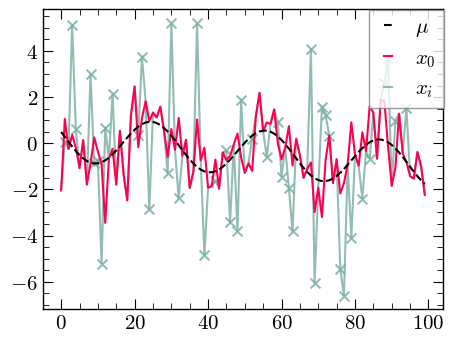

In [2]:
Nsims = 100_000
Nbins = 100
SIGMA = 1
simulator = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bounds=5, fraction=0.5, bkg=True, dtype=torch.float32, device='mps')     
samples = simulator.sample(Nsims=Nsims)

fig, ax1 = pf.create_plot(size=(4,3))

ax1.plot(samples['mu'][0].cpu(), label=r'$\mu$', c='k', ls='--', zorder=10)
ax1.plot(samples['x0'][0].cpu(), label='$x_0$',color='#ff004f', zorder=9)
ax1.plot(samples['xi'][0].cpu(), label='$x_i$', color='#77aca2', alpha=.8)
idx = torch.where(samples['ni'][0] != 0)
ax1.scatter(idx[0].cpu(), (samples['xi'][0].cpu())[idx[0].cpu()], marker='x', s=50, color='#77aca2', alpha=.8)
fig.legend()
pf.fix_plot([ax1])


## Analytical Utils
Next we want a maxmimum likelihood estimation (MLE) of the data, so that we can compare with the network's profiled likelihood. For this we use the function best_fit() from simulator.utils, which simply does a scipy data fit on some model data. Note that each time we take a copy of the dotted line mu, apply some random pertubation from the standard normal, and then best fit these - this then gets plotted each time: we expect the spread across the line to look something like a normal distribution (which it visually does!). Again this is created stochastically so the plot looks different each time.

*Note that this step isn't needed for when we build the pipeline as it is more involved with sampling from a posterior distribution - but shows us the different extent to which we might expect certain samples to have*

# II: Network and Training

Now we defne our neural network. Note that we are using a 1D U-Net architechture (we are processing 1D data) from Noemi's models script. We define the epsilon training network `Network_epsilon` which has 
- self.net: the 1D U-net that maps input histograms to a per-bin output of the same shape
- `logvariance`: a learnable parameter of the same length as the number of bins (defaulted at 5) - this is the per-bin log-variance.
The model can do
- `epsilon`: given an input batch containing N lots of Nbins grids, the model will predict the epsilon that it expects at that point.
- `snr` computes the signal-to-noise ratio at each point on the grid - note that the signal to noise follows
\begin{equation}
    SNR = \frac{\varepsilon}{\sqrt{\exp \texttt{logvariance}}}
\end{equation}
- `bounds` retrns the mean variation across all the bins scaled by five - this is used to generate the amplitude of epsilon when we train. Note that we use detach to ensure it's not part of the computation graph.
And finally we define the forward training step:
1) Simulate a pertubation sampling from std normal only where ni=1
2) add the pertubation to the base signal to create an $xi = x0 + \verb|epsilon_sim|*ni$ training signal
3) Feed the data through the netowrk to get a prediced epsilon
4) Do a Loss calculation - we pick the loss calculation as the negative log-likelihood using the learned variance, and apply the loss only in bins where there are pertubation, averaging the loss over the active bins. In this case the negative log likelihood looks like
\begin{equation}
\mathscr{L}_i = \frac{(\varepsilon^{\textnormal{pred}}_i-\varepsilon^{\textnormal{sim}}_i)^2}{\exp \texttt{logvariance}_i} + \texttt{logvariance}_i
\end{equation}

In [3]:
from models.online_norm import OnlineStandardizingLayer
from models.unet_1d import UNet1d 
from models.resnet_1d import ResidualNet


class Network_epsilon(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.online_norm = OnlineStandardizingLayer((Nbins,), use_average_std=False) 
        self.net = UNet1d(1, 1, sizes=(8, 16, 32, 64, 128))
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
        # self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x
                
    def epsilon(self, x):
        # x = self.online_norm(x)
        x = self.net(x.unsqueeze(1)).squeeze(1) # x-net
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):
        
        # Adaptive data generation
        ni = x['ni']
        epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni
        data =  x['x0'] + epsilon_sim * ni
        
        # data = x['x']
        epsilon = self.epsilon(data)
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_sim)**2                                                  # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
        return (l * mask.float()).sum() * 0.5

Now we need to actually train the network - note that I have modified it to not many epochs here as this will run really slowly on mac - mps doesn't support memory sharing between gpu cores so I can only use a single worker to load data (which causes this to run very slowly).,

Resample prepares the data after it has loaded and makes sure it's formatted correctly for training. Sample takes a sample from the simulator, and sets the sample x to the peturbed version to train the netowrk off. Then we take the first sample from each batch and returns it.

Then we set up the batch size, generate some samples and load them into a lighning datamodule.

We create an instance of the neural network and I customise it here so it goes to the mps GPU, setting weights to float32 so it works on mac.

We use Noemi's custom loss module from the utils module and then finally use the lightning trainer as described. Finally we move the model to evaluation mode - which i have to mps on my mac.



In [4]:
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']
    sample = {k: v[0] for k, v in sample.items()}
    return sample

batch_size = 128
samples = simulator.sample(Nsims=Nsims)  
dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
network_epsilon = Network_epsilon().to(dtype=torch.float32, device='mps')
model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
trainer = pl.Trainer(
    accelerator="mps", 
    max_epochs=20, 
    precision=32,
)
trainer.fit(model, dm)
# network_epsilon.cuda().eval(); # for gpu
network_epsilon.to('mps').eval() # for mac

[phobos:27383] shmem: mmap: an error occurred while determining whether or not /var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T//ompi.phobos.501/jf.0/3393454080/sm_segment.phobos.501.ca440000.0 could be created.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Network_epsilon(
  (online_norm): OnlineStandardizingLayer()
  (net): UNet1d(
    (inc): DoubleConv1d(
      (double_conv): Sequential(
        (0): Conv1d(1, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
        (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
    )
    (downs): ModuleList(
      (0): Down1d(
        (maxpool_conv): Sequential(
          (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): DoubleConv1d(
            (double_conv): Sequential(
              (0): Conv1d(8, 16, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
              (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU()
       

## Viewing the training progress

Now we convert the training loss and bound history to scalar lists that we are storing on the CPU - as a sanity check that stuff is working and our values are converging we plot the train loss and bound change as a function of the computing epoch below. Remember that the bounds are the 5sigma deviations of the logvariance for the noise level.

True

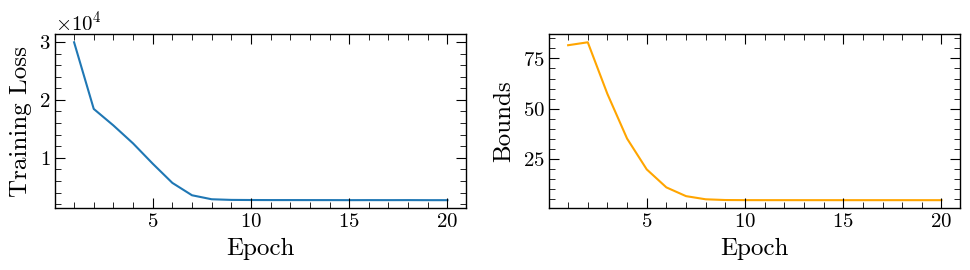

In [5]:
# Convert tensors to scalars if they are tensors
train_loss_history = [loss.item() if hasattr(loss, 'item') else loss for loss in model.train_loss_history]
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]

# Generate a list of epoch numbers
epochs = range(1, len(train_loss_history) + 1)

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
# Plot Training Loss over Epochs
axs[0].plot(epochs, train_loss_history)
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Training Loss')
# Plot Bounds over Epochs
axs[1].plot(epochs, bounds_history, label='Bounds', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Bounds')
plt.tight_layout();

pf.fix_plot(axs)

## Visualising the network at each epoch,

Having trained network_epsilon using the custom loss function that gives us the bounds above, we're now using the bounds to visualise how much distortion the model will allow for at each epoch. Again we convert the tensor to a list on the cpu and also take a sample mask from the simulator. We setup a grid of plots and go through the bounds_history individually, and plot a sample of 10 possible xi generations. Note that since the network converges after about 7 epochs in this case, we see little variation after plot 7. We are effectively saying

**what kind of distortions does our NN think is acceptible at each epoch?**

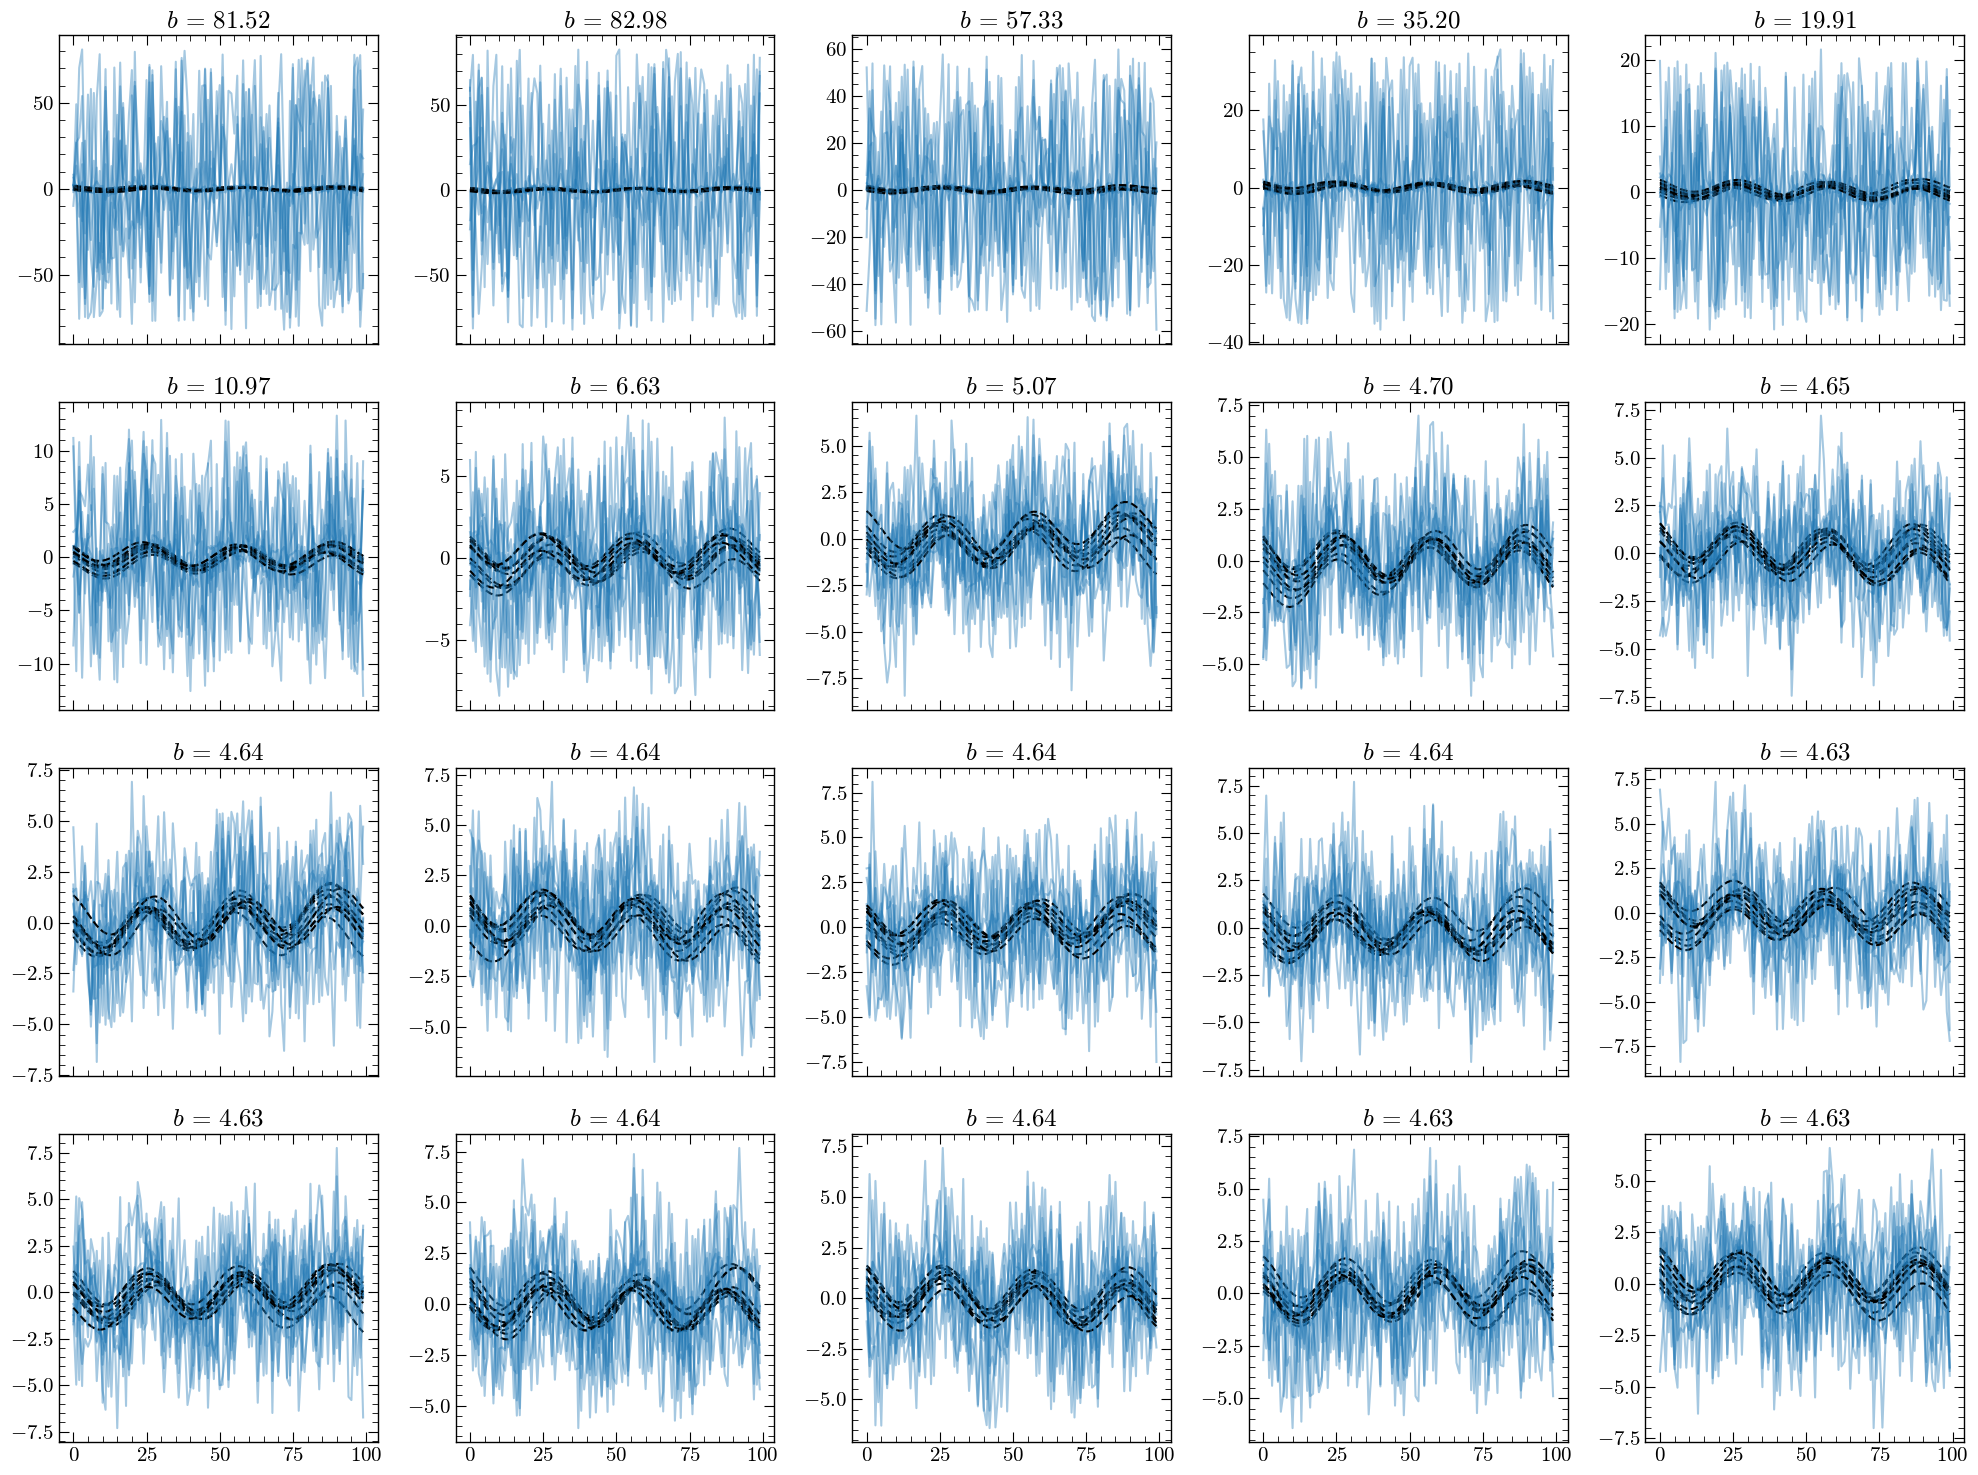

In [6]:
# Distotions enveloping the data
bounds_history = [bound.item() if hasattr(bound, 'item') else bound for bound in model.bounds_history]
sample = simulator.sample(1)
ni = sample['ni']

fig, axs = plt.subplots(4, 5, figsize=(20, (4+1)*3), sharex=True)
axs = axs.flatten()
for i_b, b in enumerate(bounds_history):
    if i_b < len(axs):
        axs[i_b].set_title(r"$b$ = {:.2f}".format(b))
        for j in range(10):
            sample = simulator.sample(1)
            ni = sample['ni']
            axs[i_b].plot(sample['mu'][0].cpu(), c='k', ls='--')
            epsilon_sim =  (2 * b * torch.rand(sample['xi'].shape, device= sample['xi'].device, dtype= sample['xi'].dtype) - b) * ni
            data =  sample['x0'] + epsilon_sim * ni
            axs[i_b].plot(data[0].cpu(), c='C0', alpha=0.4)
pf.fix_plot(axs)
plt.tight_layout()


# III: Evaluation

Let's first create a new instance of the simulator using the learned bounds from the training model. We take our learned epsilon bounds, put them on the cpu and then create a simulator based on that

In [7]:
bounds = network_epsilon.bounds().detach().cpu().numpy()
simulator = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=True, bounds=bounds, fraction=0.5, dtype=torch.float32)     # Just one bin is distorted with fraction=None  

Now we need to compare the **true distortion**, $\varepsilon$, with the **variance** $\sigma^2$; we compare between the observed data and the NN's estimate.

1) We sample a data point and calculate residuals, this is just using the MLE best fit from earlier. `delta_x` is our residual.
2) We then create the diagonal matrix ni which contains an indepentent indicator of which bins are affected and which aren't
   - The NN predictions, indicated by the nn postfix, simply draw from the network_epsilon that we trained and converged earlier.
   - We calculate our obs trivially from the simulator
3) We then plot these metrics, indicating distorted with yellow. See below for the parity plots.

/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/264747369.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout();


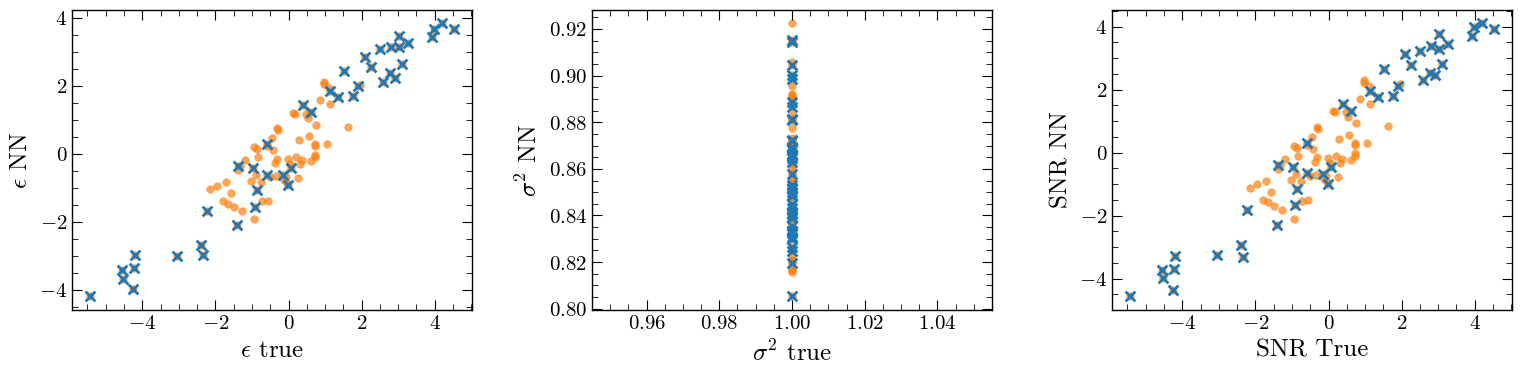

In [8]:
######### - 1 - ###########

n = 50
obs = simulator.sample(1)  
fit = best_fit(obs['xi'][0], simulator)
delta_x = (obs['xi'] - fit).to(dtype=torch.float32)

######### - 2 - ###########

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)

# epsilon_nn_obs = network_epsilon.epsilon(delta_x.cuda()).detach().cpu().numpy().squeeze(0)
epsilon_nn_obs = network_epsilon.epsilon(delta_x.to(dtype=torch.float32,device='mps')).detach().cpu().numpy().squeeze(0)
variance_nn_obs = network_epsilon.logvariance.exp().detach().cpu().numpy()
# snr_nn_obs = network_epsilon.snr(delta_x.cuda()).detach().cpu().numpy().squeeze(0)
snr_nn_obs = network_epsilon.snr(delta_x.to(dtype=torch.float32,device='mps')).detach().cpu().numpy().squeeze(0)

epsilon_obs = get_epsilon(delta_x, ni).squeeze(0)
variance_obs = 1 / get_sigma_epsilon_inv2(ni)
snr_obs = get_snr(delta_x, ni).squeeze(0)

######### - 3 - ###########

fig, ax1 = pf.create_plot(size=(4,3))
ax2 = fig.add_axes((1.3,0,1,1))
ax3 = fig.add_axes((2.6,0,1,1))
axs = [ax1,ax2,ax3]

axs[0].scatter(x=epsilon_obs, y=epsilon_nn_obs, c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)
axs[1].scatter(x=variance_obs, y=variance_nn_obs, c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)
axs[2].scatter(x=snr_obs, y=snr_nn_obs, c='C1', s=30, marker='o',linewidths=0.4, alpha=0.7)    

idx = torch.where(obs['ni']==1)[1]
axs[0].scatter(x=epsilon_obs[idx], y=epsilon_nn_obs[idx], c='C0', s=50, marker='x',linewidths=2)
axs[1].scatter(x=variance_obs[idx], y=variance_nn_obs[idx], c='C0', s=50, marker='x',linewidths=2)
axs[2].scatter(x=snr_obs[idx], y=snr_nn_obs[idx], c='C0', s=50, marker='x',linewidths=2)   


axs[0].set_xlabel(r'$\epsilon$ true')
axs[0].set_ylabel(r'$\epsilon$ NN')
axs[1].set_xlabel(r'$\sigma^2$ true')
axs[1].set_ylabel(r'$\sigma^2$ NN')
axs[2].set_xlabel('SNR True')
axs[2].set_ylabel('SNR NN')
pf.fix_plot(axs)
plt.tight_layout();

Now we'll do some frequentist stats. We set up a test statistic $t_i$ for each bin that is proportional to the SNR$^2$ in that bin 
\begin{equation}
t_i \propto \textnormal{SNR}^2
\end{equation}
We are assuming stationary noise here so diagonal covariance, and we then run a MC simulation under the null hypothesis to compute the squared SNR $\varepsilon^2/\sigma$ at each bin, with $\varepsilon$ predicted by the network. We then concatenate all of these batches into a single array, that gives us a null distribution of the SNR$^2$ per bin.

In [9]:
N_mc = 2e6

ni = torch.eye(Nbins, dtype=obs['xi'].dtype)
variance = 1 / get_sigma_epsilon_inv2(ni)

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
ts_bin_H0_epsilon = []
for _ in tqdm(range(N_batch)):
    mc_samples = simulator.sample(batch_size)
    ts_batch =  (network_epsilon.snr(mc_samples['x0'].to(device='mps', dtype=torch.float32))**2).detach().cpu().numpy()
    ts_bin_H0_epsilon.append(ts_batch)
    
ts_bin_H0_epsilon = np.concatenate(ts_bin_H0_epsilon)
ts_bin_H0_epsilon.shape

100%|█████████████████████████████████████████| 488/488 [00:12<00:00, 38.08it/s]


(1998848, 100)

# IV: Statistics

## Monte-Carlo Tests of Samples

We'll now compare this distribution against a $\chi^2$ distribution that has one degree of freedom, sampling four random separate bins from the big distribution we've just created. Under the assumptions we've laid out above, we expect them to follow the distribution, given that the covariance is diagonal

<>:12: SyntaxWarning: invalid escape sequence '\c'
<>:12: SyntaxWarning: invalid escape sequence '\c'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/558450320.py:12: SyntaxWarning: invalid escape sequence '\c'
  axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')


True

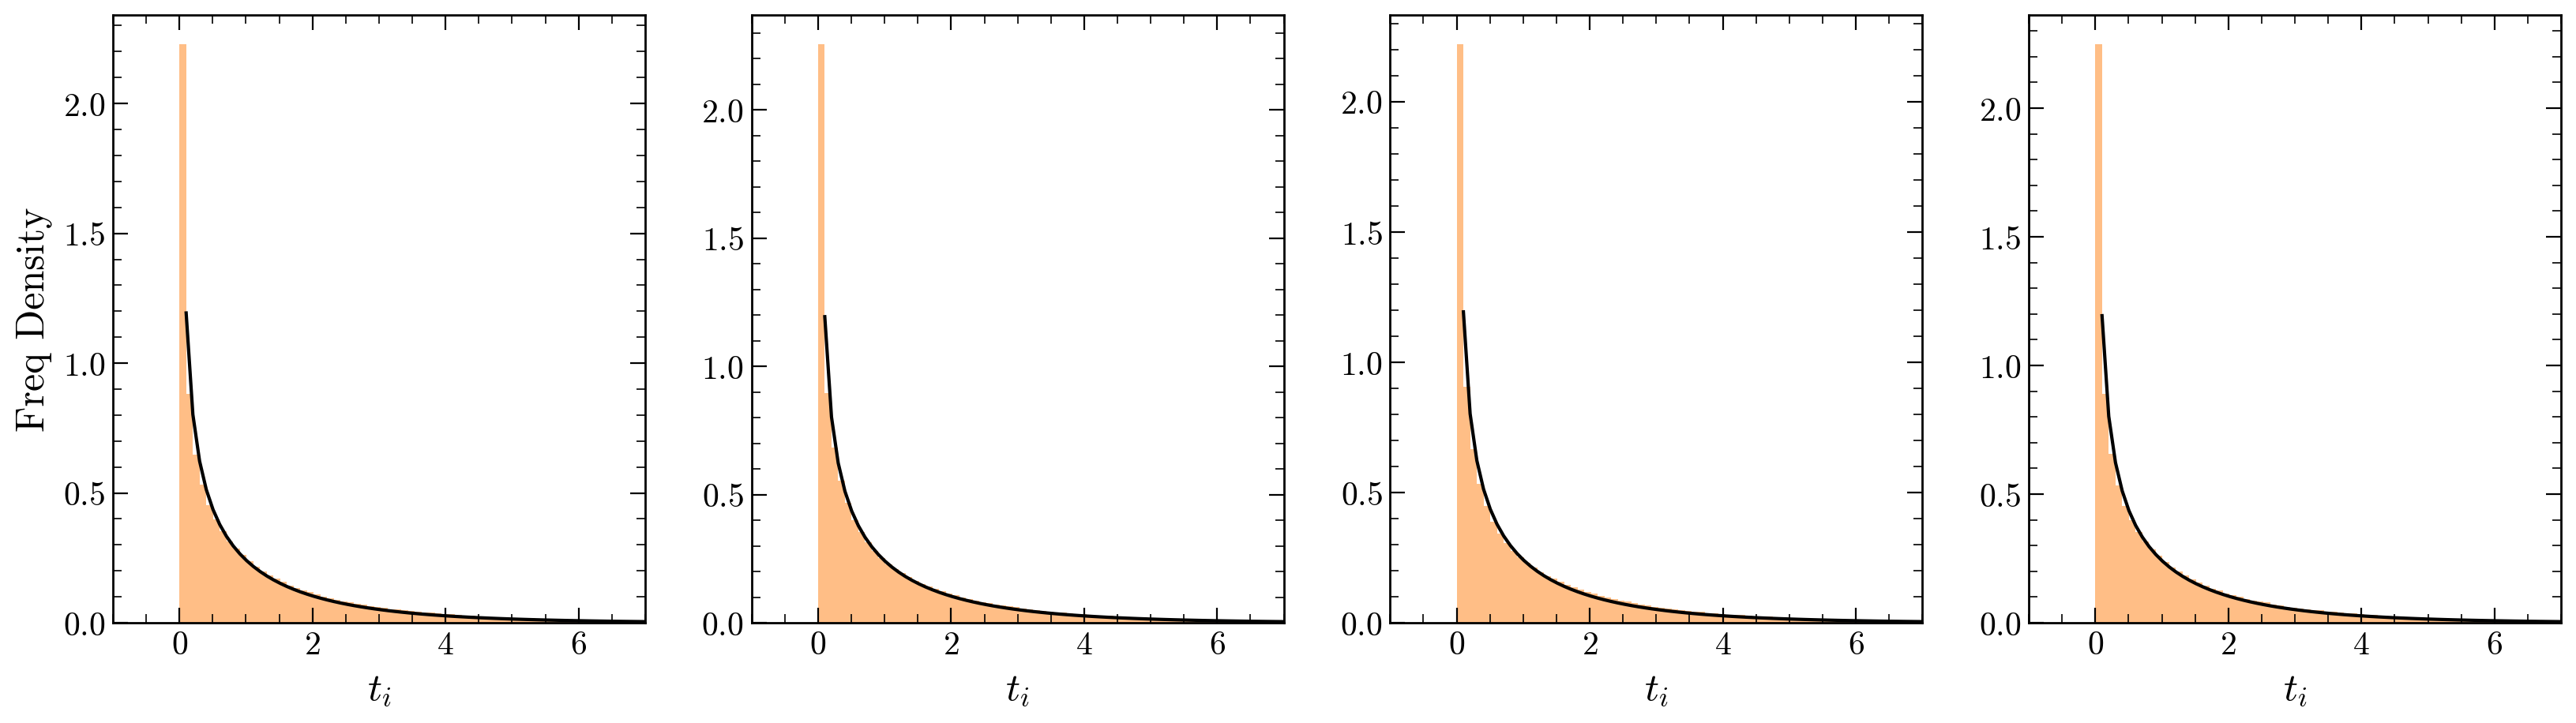

In [10]:
grid = np.linspace(0, 10, 100) # 1 df, adjust
chi2 = scipy.stats.chi2.pdf(grid, df=1, loc=0)

fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=200)
for i in range(4):
    bin = torch.randint(Nbins, (1,))
    ts_bin_i = ts_bin_H0_epsilon[:, bin]
    bins = np.linspace(0, 10, 100)
    axs[i].hist(ts_bin_i, bins=bins, density=True, color='C1', alpha=0.5)    
    axs[i].set_xlabel('$t_i$')
    axs[i].set_xlim(-1, 7)
    axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')
axs[0].set_ylabel('Freq Density')
pf.fix_plot(axs)

Next, let's do a multi-panel vizialisation of the what the network estimates vs what the simulator generates for distortions, their test statistic $t(x) \sim \textnormal{SNR}^2$ and their p-values, across a couple of different samples from our MC distribution.

As always, we'll start with a sample from the simulator and get our xi, mu, ni and epsilon. We'll also get the network to estimate the epsilon and the SNR given the xi from the generator. We also want to fit the model data to some curve, so we'll use Noemi's best_fit for this, and get an analytical expression for epsilon and the snr from our data.

This shows the test statistic in most cases pretty accurately predicting when we have a distortion - when we apply an epsilon, the test statistic drops very low and is the NN effectively flagging 'this looks like a distortion'. As we expect from the parity plots, it's currently underestimating the SNR - this may just be because we haven't trained it for particularly long

<>:78: SyntaxWarning: invalid escape sequence '\m'
<>:78: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/3973829163.py:78: SyntaxWarning: invalid escape sequence '\m'
  axs[3, 0].set_ylabel("$\mathrm{p}_i$")


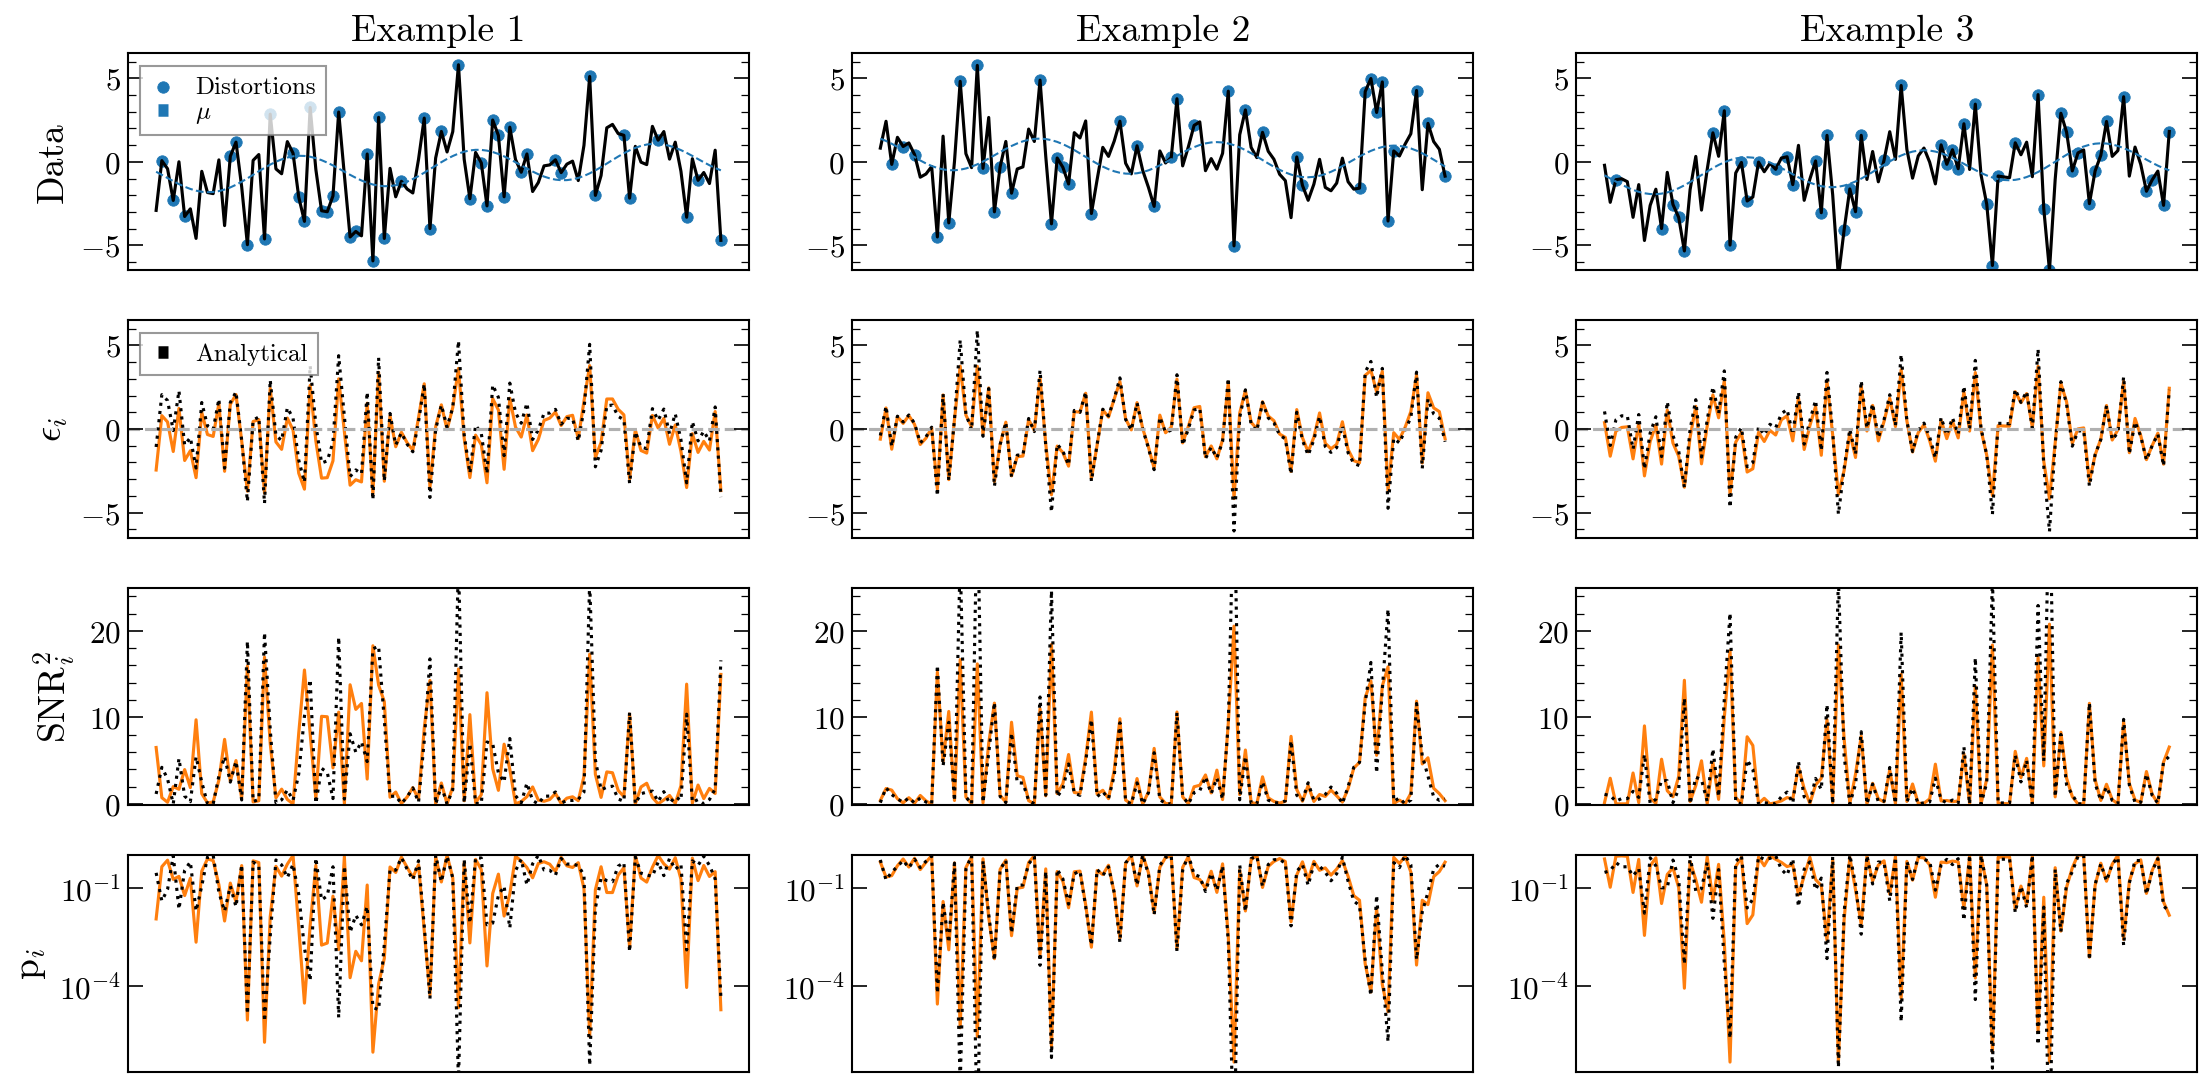

In [15]:
#### NOTE - MIST GOF LIBRARY DOESN'T EXIST - TAKING A GUESS AT HOW THESE FUNCTIONS WORK ####
def t_to_pvalue(ts, df=1):
    return 1 - scipy.stats.chi2.cdf(ts, df)

def t_to_pvalue_empirical(ts_obs, ts0_ref):
    ts0_ref = np.asarray(ts0_ref)
    return (np.sum(ts0_ref >= ts_obs) + 1) / (len(ts0_ref) + 1)


### - NOEMI'S CODE - ###
fig, axs = plt.subplots(4, 3, figsize=(15, 7.5), dpi=150)
for i in range(3):
    
    ### - GET SAMPLE - ###
    obs = simulator.sample(1) 
    
    ### - GET NN EPS AND SNR - ###
    epsilon_nn = network_epsilon.epsilon(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)
    snr2_nn = network_epsilon.snr(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)**2
    
    ### - ANALYTICAL COMPUTE SNR AND EPS - ###
    ni_temp = torch.eye(Nbins, dtype=torch.float64)
    fit = best_fit(obs['xi'][0], simulator)
    delta_x = obs['xi'] - fit
    epsilon_analytical = get_epsilon(delta_x, ni_temp).squeeze(0)
    snr2_analytical = get_snr(delta_x, ni_temp).squeeze(0)**2

    ### - COMPUTE P VALUES - ###
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(snr2_nn):
        ts_bin_i = ts_bin_H0_epsilon[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
        _p_analytical.append(t_to_pvalue(snr2_analytical[idx], 1)) # 1 dof per bin
    p_nn = np.array(_p_nn) 
    p_analytical = np.array(_p_analytical)   
    
    ### - PLOT - ###
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    epsilon = obs['epsilon'][0] 
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    axs[0, i].set_xticks([])

    axs[1, i].plot(grid, epsilon_nn, c='C1')
    axs[1, i].plot(grid, epsilon_analytical, c='k', ls='dotted', label='Analytical')
    axs[1, i].set_ylim(-6.5, 6.5)
    axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')
    axs[1, i].set_xticks([])
    
    axs[2, i].plot(grid, snr2_nn, c='C1')
    axs[2, i].plot(grid, snr2_analytical, c='k', ls='dotted', label='Analytical')
    axs[2, i].set_ylim(-0.1, 25)
    axs[2, i].set_xticks([])

    axs[3, i].semilogy(grid, p_nn, c='C1')
    axs[3, i].semilogy(grid, p_analytical, c='k', ls='dotted', label='Analytical')
    axs[3, i].set_ylim(1/N_mc/2, 1)
    axs[3, i].grid(True, axis='y')
    axs[3, i].set_xticks([])
    
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel(r"$\epsilon_i$")
axs[1, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[2, 0].set_ylabel(r"$\mathrm{SNR}^2_i$")
axs[3, 0].set_ylabel("$\mathrm{p}_i$")
for ax in axs:
    pf.fix_plot(ax)
plt.tight_layout();


Now we'll do a distribution of the total test statistic - we will sum $t(x)$ over many bins under the null hypothesis, and compare it analytically with the $\chi^2$ distribution we expect for this number of DoF. We're doing this under the null hypothesis.

We fit 3 parameters, so it follows that our DoF is Nbins-3. We then take the sum of $t(x)$ that follows
\begin{equation}
t_{\textnormal{sum}}(x)=\sum^N_{i=1} -2 \log \frac{\mathbb{P}(x|H_0)}{\mathbb{P}(x|H_1)}
\end{equation}
`ts_bin_H0_epsilon` computes a global test statistic per MC sample by summing all bin-wise test statistics. This will be binned by a histogram later. `ts_sum_H0_epsilon_mean` Computes the empirical mean of the global test statistic distribution - we need this to compare with a chisq distribution. The final line centres the empirical distribution around $(0,0)$ by subtracting the mean so that we can compare with the chisq distribution.

We note that since $t_{\textnormal{sum}}<\chi^2$ around 0; this is a consequence of it underestimating the signal to noise (which we see in the above plot), which is causing it to underestimate the true test statistic. We see this in the plot above's p-pane where the yellow line often drops below the analytical model on detections.

True

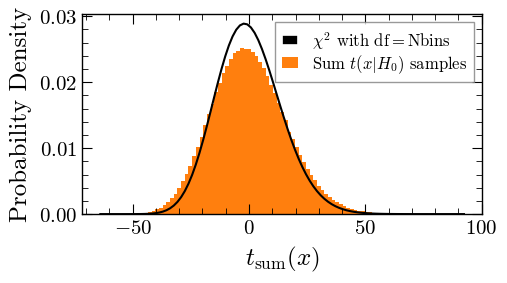

In [51]:
DOF = Nbins - 3 # 3 parameters

#### - TAKING FROM OUR MCMC ABOVE - ####
ts_sum_H0_epsilon = ts_bin_H0_epsilon.sum(axis=1)
ts_sum_H0_epsilon_mean = ts_sum_H0_epsilon.mean()
ts_sum_H0_epsilon = ts_sum_H0_epsilon - ts_sum_H0_epsilon_mean

#### - PLOT - ####
fig, ax1 = pf.create_plot(size=(4,2))
bins = np.linspace(ts_sum_H0_epsilon.min(), ts_sum_H0_epsilon.max(), 100)
ax1.plot(bins, scipy.stats.chi2.pdf(bins, df=DOF, loc=-DOF), c='k', label=r'$\chi^2$ with df$=$Nbins')
ax1.hist(ts_sum_H0_epsilon, bins=bins, density=True, color='C1', label='Sum $t(x|H_0)$ samples')
ax1.legend(loc='best', fontsize=12, labelspacing=0.1)
ax1.set_xlabel(r'$t_{\mathrm{sum}}(x)$')
plt.ylabel("Probability Density")

pf.fix_plot([ax1])

Now let's visualise how well our NN applroximates $t$ to detect a distortion by comparing it against the true calculation of t in some samples from our MC distribution. We start off as usual by creating ourselves a simulator with bounds trained on the neural network, and for each plot column we take a random sample from the simulator, just as if we were sampling from a distribution by taking a measurement in real life.

First we figure out what the neural network thinks $\varepsilon$ and $\mathrm{SNR}^2$ is given the `xi` from the generator, and we also sum the $\mathrm{SNR}^2$ across all bins. By comparing our summed value of t with the distribution of $\varepsilon$ under the null hypothesis, we can get ourselves a p-value of the total statistic compared to the null distribution. 

Next, we'll do an analytical calculation of what the exact distortion is - so we do a best fit of xi, figure out the residuals, calculate $\varepsilon$, turn that into a $\mathrm{SNR}^2$ and analytically turn it into a p-value from the theoretical $\chi^2$ with `nbins` degrees of freedom. This gets turned into a plot with three rows:

1) The data - observed xi against true mean, and which bins have been distorted
2) the *cumulative* p-values, which compares the empirical p-value from the neural network with the analytical one derived from the data - we ask 'is the NN assigning p-values of the right size compared to the true distortions'
3) the comparative histogram of the NN/analytical epsilons normalised by the total variance. This is showing us how spread out/accurate the estimates of the episilon are compared to the true distribution.


<>:57: SyntaxWarning: invalid escape sequence '\e'
<>:63: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\e'
<>:63: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/3406371273.py:57: SyntaxWarning: invalid escape sequence '\e'
  axs[2, i].set_xlabel("$\epsilon / \sigma$")
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/3406371273.py:63: SyntaxWarning: invalid escape sequence '\m'
  axs[1, 0].set_ylabel("$\mathrm{p}_\mathrm{sum}$")
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/3406371273.py:55: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  axs[2, i].hist(epsilon_analytical/np.sqrt(variance_analytical), bins=bins, density=True, color='k', alpha=0.4, label='Analytical')
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/3406371273.py:55: Deprecati

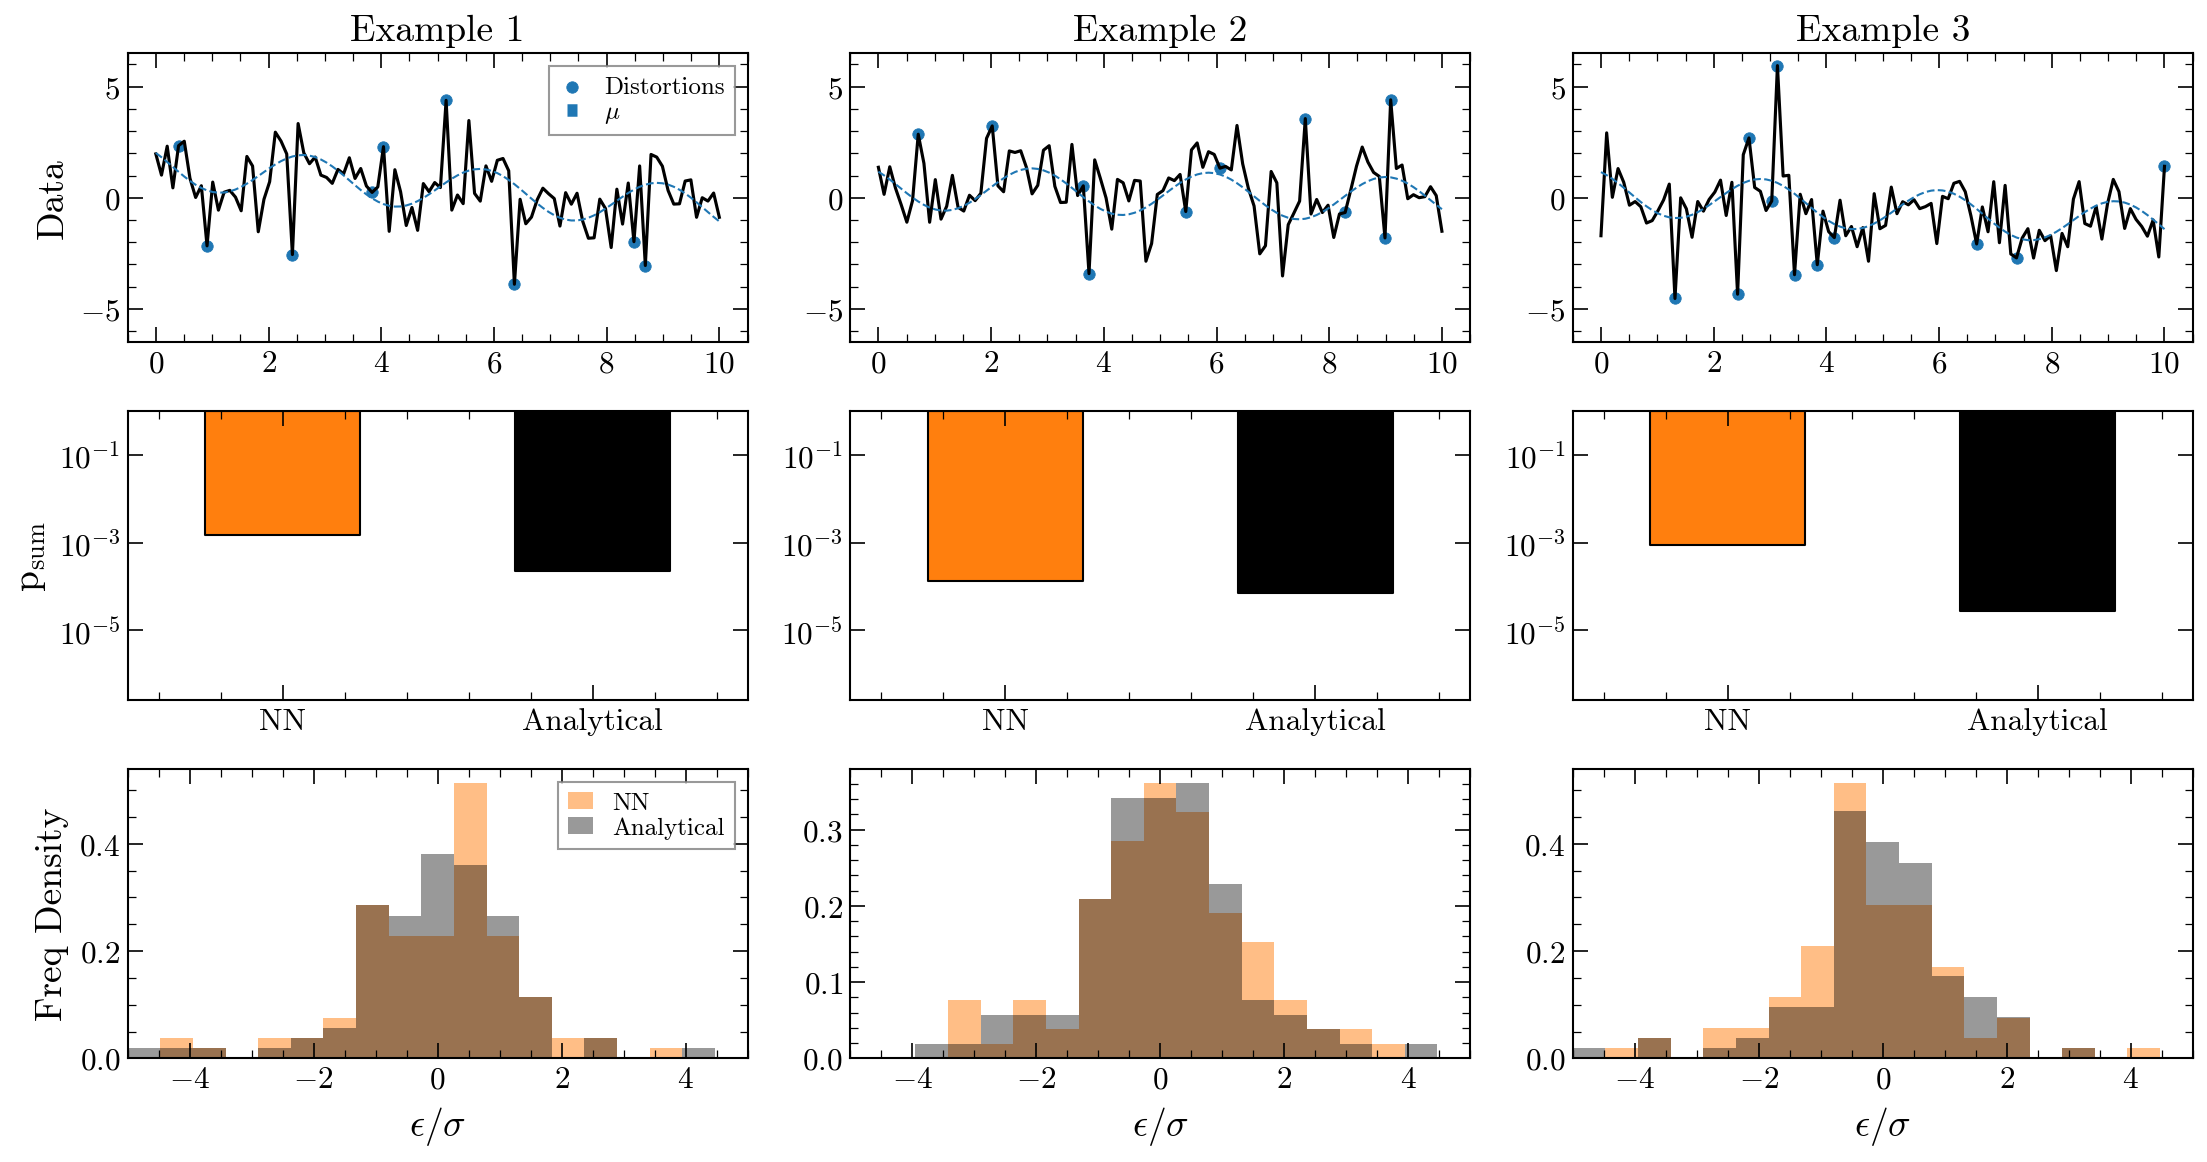

In [49]:
### - INITIALISE SIMULATOR - ###
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=True, bounds=bounds, fraction=0.1, dtype=torch.float64)     

fig, axs = plt.subplots(3, 3, figsize=(15, 8), dpi=150)
for i in range(3):
    
    ### - GET A SAMPLE - ###
    simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=True, bounds=bounds, fraction=0.1, dtype=torch.float64)     
    obs = simulator1.sample(1) 
    
    ### - EVALUATE EPSILON AND SNR^2 FROM NN - ###
    epsilon_nn = network_epsilon.epsilon(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)
    # epsilon_nn = network_epsilon.epsilon(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)
    snr2_nn = network_epsilon.snr(obs['xi'].to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)**2
    # snr2_nn = network_epsilon.snr(obs['xi'].cuda()).detach().cpu().numpy().squeeze(0)**2
    variance_nn = network_epsilon.logvariance.exp().detach().cpu().numpy()
    ts_sum_nn = snr2_nn.sum()-ts_sum_H0_epsilon_mean
    p_sum_nn = t_to_pvalue_empirical(ts_sum_nn, ts_sum_H0_epsilon)   
    
    ### - COMPUTE ANALYTICALLY - ###
    ni_temp = torch.eye(Nbins, dtype=torch.float64)
    fit = best_fit(obs['xi'][0], simulator)
    delta_x = obs['xi'] - fit
    epsilon_analytical = get_epsilon(delta_x, ni_temp).squeeze(0)
    variance_analytical = 1 / get_sigma_epsilon_inv2(ni_temp)
    snr2_analytical = get_snr(delta_x, ni_temp).squeeze(0)**2
    ts_sum_analytical = snr2_analytical.sum() - Nbins #((sample['xi'])**2/SIGMA**2).sum()-Nbins
    p_sum_analytical = t_to_pvalue(ts_sum_analytical+Nbins, Nbins)  
    
    ### - PLOT - ###
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    epsilon = obs['epsilon'][0] 
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim(1/(N_mc*2), 1)
    axs[1, i].set_xticks([0, 1])
    axs[1, i].set_xticklabels(['NN', 'Analytical'])
    axs[1, i].set_xlim(-0.5, 2 - 0.5)
    axs[1, i].grid(True)
    for x, value, color in zip([0, 1], [p_sum_nn, p_sum_analytical], ['C1', 'k']):
        left = x - 0.5 / 2
        right = x + 0.5 / 2
        axs[1, i].fill_between([left, right], 1, value, facecolor=color, edgecolor='black')
    
    bins = np.linspace(-5*SIGMA, 5*SIGMA, int(Nbins/5))
    axs[2, i].hist(epsilon_nn/np.sqrt(variance_nn), bins=bins, density=True, color='C1', alpha=0.5, label='NN')
    axs[2, i].hist(epsilon_analytical/np.sqrt(variance_analytical), bins=bins, density=True, color='k', alpha=0.4, label='Analytical')
    axs[2, i].set_xlim(-5*SIGMA, 5*SIGMA)
    axs[2, i].set_xlabel("$\epsilon / \sigma$")
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel("$\mathrm{p}_\mathrm{sum}$")
axs[2, 0].set_ylabel('Freq Density')
axs[2, 0].legend(loc='best', fontsize=12, labelspacing=0.1)

for ax in axs:
    for a in ax:
        pf.fix_plot([a])
plt.tight_layout();

Now we are going to get empirical p-value distributions for each bin under $H_0$ which we can use to compare with the real data such that we can surmount evidence to accept/reject $H_0$. This code does exactly that - aggregates our MC data, sorts it (giving the empirical distribution of $t$ under $H_0$), computes the ranks (telling us how extreme a value of t is in relation to the rest of the sample - high rank=more extreme) and converts these to p-values by normalising them. We then store these p-values under the null giving it the same shape as `ts_bin_H0_epsilon`, such that `pv_bin_H0` has rows of monte carlo sample, and columns of the empirical p-value under $H_0$.

In [54]:
N_mc, num_bins = ts_bin_H0_epsilon.shape
ts_bin_flat = ts_bin_H0_epsilon.reshape(N_mc, num_bins)
means = ts_bin_flat.mean(axis=0)  # Shape: [num_bins]
ts_centered = ts_bin_flat - means  # Shape: [N_mc, num_bins]

# Sort the centered data along N_mc axis
sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_bins]
# Compute ranks for all values
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
# Compute p-values
p_values = (ranks + 1) / N_mc
# Reshape back to [N_mc, num_bins]
pv_bin_H0 = p_values.reshape(N_mc, num_bins)    

pv_bin_H0.shape

(1998848, 100)

We now select some random bins (ie random simulations of the dataset - we have simulated 100 random simulations above) and plot the histogram of the p-values in this bin, to show that within each bin the p-values are uniformly distributed between zero and one. We expect this as we effectively gave each value a rank, so this is basically just a sanity check!!!

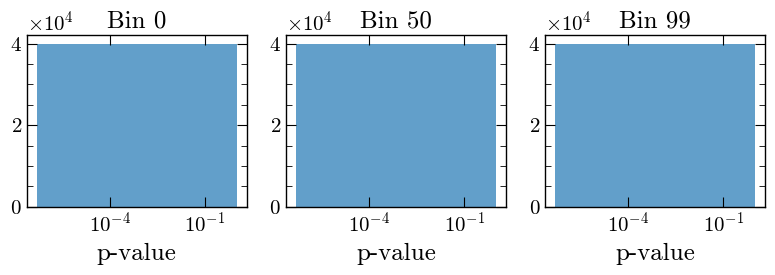

In [62]:
selected_bins = [0, 50, 99]            # Bins to plot
fig, axs = plt.subplots(1, len(selected_bins), figsize=(8, 3))
for j, bin_idx in enumerate(selected_bins):
    pv_data = pv_bin_H0[:, bin_idx]
    axs[j].hist(pv_data, bins=50, alpha=0.7)
    axs[j].set_title(f'Bin {bin_idx}')
    axs[j].set_xscale('log')
    axs[j].set_xlabel('p-value')

pf.fix_plot(axs)
plt.tight_layout()
plt.show()

**WORTH CHECKING WITH JAMES**

We now want to check the correlation between the p-values between different simulations (ie different bins). These plots illustrate something called the look elsewhere effect, which is a virtue of carrying out lots of tests we are more likely to see a deviation that exceeds a certain threshold.

NB: waiting on a response from naomi!



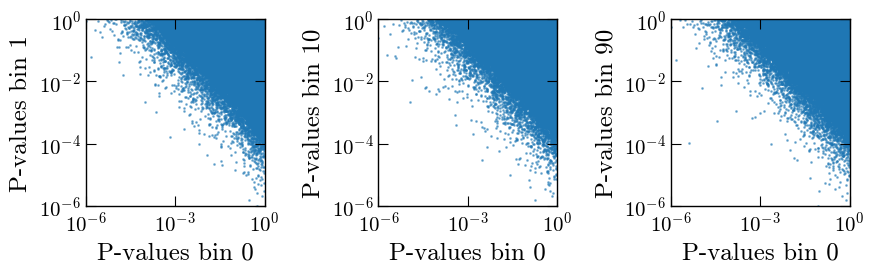

In [ ]:
bins_pairs = [(0, 1), (0, 10), (0, 90)]

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, (bin1, bin2) in enumerate(bins_pairs):
    p_values_res1 = pv_bin_H0[:, bin1]
    p_values_res2 = pv_bin_H0[:, bin2]

    axs[i].scatter(p_values_res1, p_values_res2, alpha=0.5, s=1)
    axs[i].set_xlabel(f'P-values bin {bin1}')
    axs[i].set_ylabel(f'P-values bin {bin2}')
    axs[i].set_xlim(1e-6, 1)
    axs[i].set_ylim(1e-6, 1)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].grid(True)

pf.fix_plot(axs)
plt.tight_layout()
plt.show()

For our $N_{\mathrm{MC}}$ number of simulations we've taken to do the MC step, we can also look at each one, and of the 100 values we simulate, pick out the smallest P-value we get. 

True

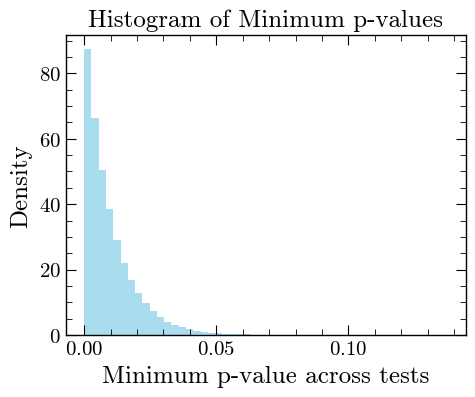

In [76]:
Nmc = pv_bin_H0.shape[0]
min_pv_bin_H0_epsilon = np.min(pv_bin_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

fig, ax1 = pf.create_plot(size=(4,3))
ax1.hist(min_pv_bin_H0_epsilon, bins=50, alpha=0.7, color='skyblue', density=True)
ax1.set_xlabel('Minimum p-value across tests')
ax1.set_ylabel('Density')
ax1.set_title('Histogram of Minimum p-values')
pf.fix_plot([ax1])

We are going to compute the empirical p-values, as before, and we'll analyse the distribution of the p-values. 

1) We start by computing the empirical t-values (we did a similar thing earlier), but now instead of calculating some local/per-bin p-values, we're going to calculate the global p-values, so we can have a look at the whole sample distribution.
2) Then, we have look at this distribution - we expect this to be uniform since we have just evenly spaced the ranks of each value across [0,1], and as we expect, the plot is uniform.
3) [need to check with noemi about the second plot because I am confused as to why this exists]
4) Finally we combine the values from the bin-wise p-values and he sum-statistic p-values, giving a full set of all the hypothesis tests. For each sample we compute the minimum-p across all tests. This plot therefore shows us how likely any (either) of the tests produce small p-values under the null - so will give us a good idea of false positives - Since we take such a large sample, it becomes likely that we do see individual very small values under $H_0$, whcih this plot illustrates.

(1998848, 101)


True

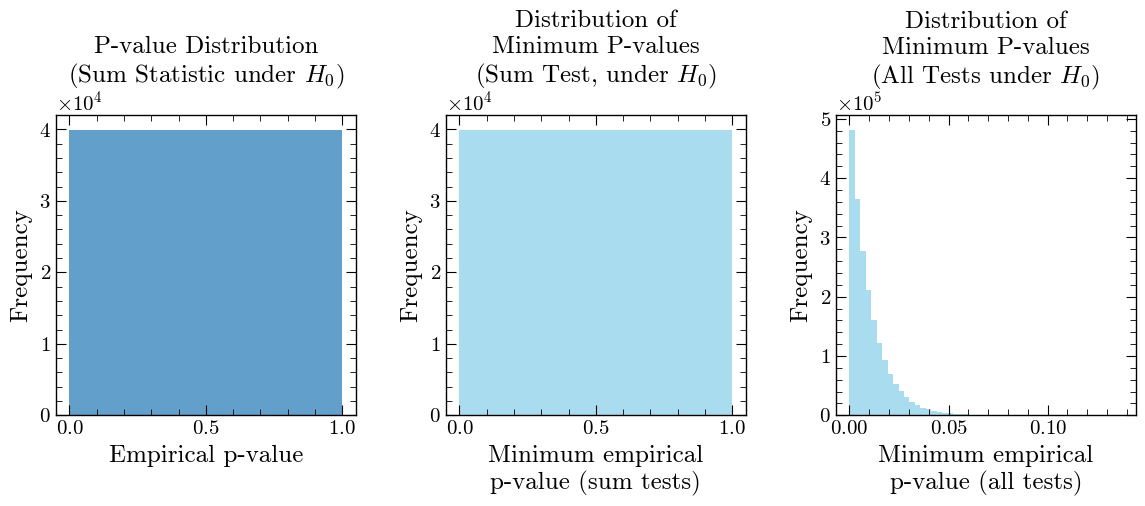

In [ ]:
### - CENTER AND RANK TS_SUM UNDER H0 - ###
# Center the test statistic (e.g., chi-squared-like) under H0 by subtracting the mean
means = ts_sum_H0_epsilon.mean(axis=0)  # Mean of summed test statistic across MC samples
ts_centered = ts_sum_H0_epsilon - means  # Centered statistic

# Sort and rank the centered values to compute empirical p-values
sorted_ts = np.sort(ts_centered, axis=0)
ranks = np.argsort(np.argsort(-ts_centered, axis=0))  # Descending ranks
p_values = (ranks + 1) / N_mc  # Empirical p-values

pv_sum_H0 = p_values  # Final p-values for the sum test
pv_sum_H0.shape  # Check shape, should be (N_mc,)

### - PLOT HISTOGRAM OF EMPIRICAL P-VALUES - ###
fig,ax1=pf.create_plot(size=(3,3))
ax1.hist(pv_sum_H0, bins=50, alpha=0.7)
ax1.set_xlabel('Empirical p-value')
ax1.set_ylabel('Frequency')
ax1.set_title("P-value Distribution\n"+r"(Sum Statistic under $H_0$)")

# This shows the distribution of the p-values under H0 for the sum test

############### THIS COULD BE A MISTAKE REPEAT PLOT ######################
### - PLOT MINIMUM P-VALUES FROM SUM TEST - ###
min_pv_sum_H0_epsilon = np.min(pv_sum_H0.reshape(Nmc, -1), axis=1)

ax2 = fig.add_axes((1.3,0,1,1))
ax2.hist(min_pv_sum_H0_epsilon, bins=50, alpha=0.7, color='skyblue')
ax2.set_xlabel('Minimum empirical\np-value (sum tests)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of\nMinimum P-values\n'+r'(Sum Test, under $H_0$)')
#########################################################################

### - COMBINE BIN-WISE AND SUM P-VALUES - ###
Nmc = pv_bin_H0.shape[0]
pv_all_H0 = np.concatenate([
    pv_bin_H0.reshape(Nmc, -1),     # Bin-wise p-values
    pv_sum_H0.reshape(Nmc, -1)      # Sum p-values
], axis=1)  # Combined shape: [N_mc, N_bins + 1]

print(pv_all_H0.shape)  # Sanity check

### - PLOT MINIMUM P-VALUES ACROSS ALL TESTS - ###
min_pv_all_H0_epsilon = np.min(pv_all_H0, axis=1)  # Take minimum p-value across all bins + sum

ax3 = fig.add_axes((2.6,0,1,1))
ax3.hist(min_pv_all_H0_epsilon, bins=50, alpha=0.7, color='skyblue')
ax3.set_xlabel('Minimum empirical\np-value (all tests)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of\nMinimum P-values\n'+'(All Tests under $H_0$)')

pf.fix_plot([ax1,ax2,ax3])

# Plotting A Summary

Finally, we'll write some code to summarise all of the information we've just looked at in one plot. We will need the following packages (copied from Noemi's code)

In [96]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker
from cycler import cycler

mygold = (218/255, 165/255, 64/255, 0.1)  

def cax(ax, pad=0.05):
    divider = make_axes_locatable(ax)
    return divider.append_axes(position='top', size='5%', pad=pad)

The following code makes the summary for the data we have just been looking at:

In [113]:
def analyse_obs_epsilon(obs):
    
    target = obs['xi']
    
    # Evaluate epsilon and SNR^2 test statistic from NN
    epsilon_nn = network_epsilon.epsilon(target.to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]
    # epsilon_nn = network_epsilon.epsilon(target.cuda()).detach().cpu().numpy().squeeze(0)       #[len(correlation_scales), Nbins]

    variance_nn = network_epsilon.logvariance.exp().detach().cpu().numpy()                            #[len(correlation_scales), Nbins]
    # variance_nn = network_epsilon.logvariance.exp().detach().cpu().numpy()                            #[len(correlation_scales), Nbins]

    snr2_nn = network_epsilon.snr(target.to(device='mps', dtype=torch.float32)).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]
    # snr2_nn = network_epsilon.snr(target.cuda()).detach().cpu().numpy().squeeze(0)**2            #[len(correlation_scales), Nbins]

    ts_sum_nn = snr2_nn.sum()-ts_sum_H0_epsilon_mean
    p_sum_nn = t_to_pvalue_empirical(ts_sum_nn, ts_sum_H0_epsilon)   

    
    # Compute analytical epsilon and SNR^2 test statistic
    ni_temp = torch.eye(Nbins, dtype=torch.float32)
    fit = best_fit(obs['xi'][0], simulator)
    delta_x = (obs['xi'] - fit).to(dtype=torch.float32)
    epsilon_analytical = get_epsilon(delta_x, ni_temp).squeeze(0)
    snr2_analytical = get_snr(delta_x, ni_temp).squeeze(0)**2
    ts_sum_analytical = snr2_analytical.sum() #((obs['xi'])**2/SIGMA**2).sum()
    p_sum_analytical = t_to_pvalue(ts_sum_analytical, DOF)

    # Compute localized p-values
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(snr2_nn):
        ts_bin_i = ts_bin_H0_epsilon[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
        _p_analytical.append(t_to_pvalue(snr2_analytical[idx], 1)) # 1 Nbins per bin
    p_nn = np.array(_p_nn) 
    p_analytical = np.array(_p_analytical)


    # Compute global p-values
    obs_min_pv_bin = p_nn.reshape(-1).min()
    obs_min_pv_sum = p_sum_nn
    pv_all_obs = np.concatenate([
        p_nn.reshape(-1),  # Shape: [Nbins]
        torch.tensor([p_sum_nn])  # Shape: [1]
    ], axis=0)  # Combined shape: [num_total_tests]
    obs_min_pv_all = pv_all_obs.min()

    p_glob_bin = np.mean(min_pv_bin_H0_epsilon <= obs_min_pv_bin)
    p_glob_all = np.mean(min_pv_all_H0_epsilon <= obs_min_pv_all)

    p_glob_bin, p_glob_all

    return epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all


def plot_analysis_epsilon(obs, epsilon_nn, epsilon_analytical, variance_nn, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all):
    
    # Figure
    c = ["C0", "C1", "C2"]
    fig = plt.figure(figsize=(10, 8), dpi=200)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

    ### FIRST PART
    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    ni = obs['ni'][0] 
    dist = obs['xi'][0] - obs['x0'][0]
    epsilon = obs['epsilon'][0] 
    grid = torch.linspace(0, Nbins, Nbins)
    ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
    ax1.fill_between(grid, obs['mu'][0]-1, obs['mu'][0]+1,  color='#b0b0b0', alpha=0.1)
    ax1.fill_between(grid, obs['mu'][0]-2, obs['mu'][0]+2,  color='#b0b0b0', alpha=0.2)
    ax1.fill_between(grid, obs['mu'][0]-3, obs['mu'][0]+3,  color='#b0b0b0', alpha=0.3)
    ax1.scatter(grid, xi, c='k', marker='x', s=6)
    ax1.plot(grid, obs['mu'][0]+dist, color = mycolors[1], ls= (0, (1, 1)), label="$\mu_{\mathrm{dist}}$")
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.legend(fontsize=13, loc='best', labelspacing=0.1)
    ax1.set_ylim(-6.5, 6.5)
    ax1.set_xticks([])
    ax1.set_title("Data")
    # ax1.set_xlabel("$i$", labelpad=1.5)


    # Second column: ax2 and ax3 in the first column c = mycolor[1]
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn, c = mycolors[1], label=r"$\mathrm{SBI}$")
    ax2.semilogy(grid, p_analytical, c='k', ls='dotted', label=r"analytical")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.legend(loc='best',  fontsize=13)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.grid(True)
    # ax2.set_xlabel("$i$", labelpad=1.5)

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.plot(grid, epsilon_nn, c = mycolors[1], label=r"$\mathrm{SBI}$")
    ax3.plot(grid, epsilon_analytical, c='k', ls='dotted',label=r"analytical")
    ax3.set_ylabel(r"$\epsilon_\mathrm{obs}$")
    ax3.legend(loc='best',  fontsize=13)
    # ax3.set_xlabel("$i$", labelpad=1.5)
    ax3.set_ylim(-6.5, 6.5)
    ax3.set_xticks([])
    ax3.set_title("Residual analysis")
    ax3.axhline(0, color='#b0b0b0', linestyle='--')


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1])
    ax4.set_xticklabels(["SBI", "Analytical"])
    ax4.set_xlim(-0.5, 2 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn, facecolor = mycolors[1], edgecolor = mycolors[1])
    ax4.fill_between([0.8, 1.2], 1, p_sum_analytical, alpha=0.2, edgecolor='k', facecolor='k', linestyle = 'dotted')
    ax4.set_title("Model validation")
    ax4.grid(True, axis='y')

    # Hist
    ax6 = fig.add_subplot(gs[2, 1])
    bins = np.linspace(-5*SIGMA, 5*SIGMA, int(Nbins/5))
    ax6.hist(epsilon_nn / np.sqrt(variance_nn), bins=bins, density=True, color = mycolors[1], alpha=0.5)
    ax6.hist(epsilon_analytical, bins=bins, density=True, histtype='step', color='k', linestyle = 'dotted')
    ax6.set_xlim(-5*SIGMA, 5*SIGMA)
    ax6.set_xlabel("$\epsilon_\mathrm{obs}/\sigma$")
    ax6.set_title("Residual variance analysis")

    # Add on gs[0, 1] text reporting the three global p-values
    ax_text = fig.add_subplot(gs[0, 1])
    mantissa, exp = ('%.2e' % p_glob_all).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.5, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax_text.axis('off')
    ax_text.set_title("Global p-value")

    axes = [ax1,ax2,ax3,ax4,ax6]
    pf.fix_plot(axes)

    plt.tight_layout();

<>:73: SyntaxWarning: invalid escape sequence '\m'
<>:78: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:91: SyntaxWarning: invalid escape sequence '\m'
<>:120: SyntaxWarning: invalid escape sequence '\m'
<>:132: SyntaxWarning: invalid escape sequence '\e'
<>:73: SyntaxWarning: invalid escape sequence '\m'
<>:78: SyntaxWarning: invalid escape sequence '\m'
<>:79: SyntaxWarning: invalid escape sequence '\m'
<>:91: SyntaxWarning: invalid escape sequence '\m'
<>:120: SyntaxWarning: invalid escape sequence '\m'
<>:132: SyntaxWarning: invalid escape sequence '\e'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/4061610990.py:73: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/4061610990.py:78: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(grid, obs['mu'][0]+dist, color = mycolors[1], l

**And then we will run this code to actually make the plot:**

(np.float64(0.00012957457016513004), np.float64(2.523960285216731e-07))

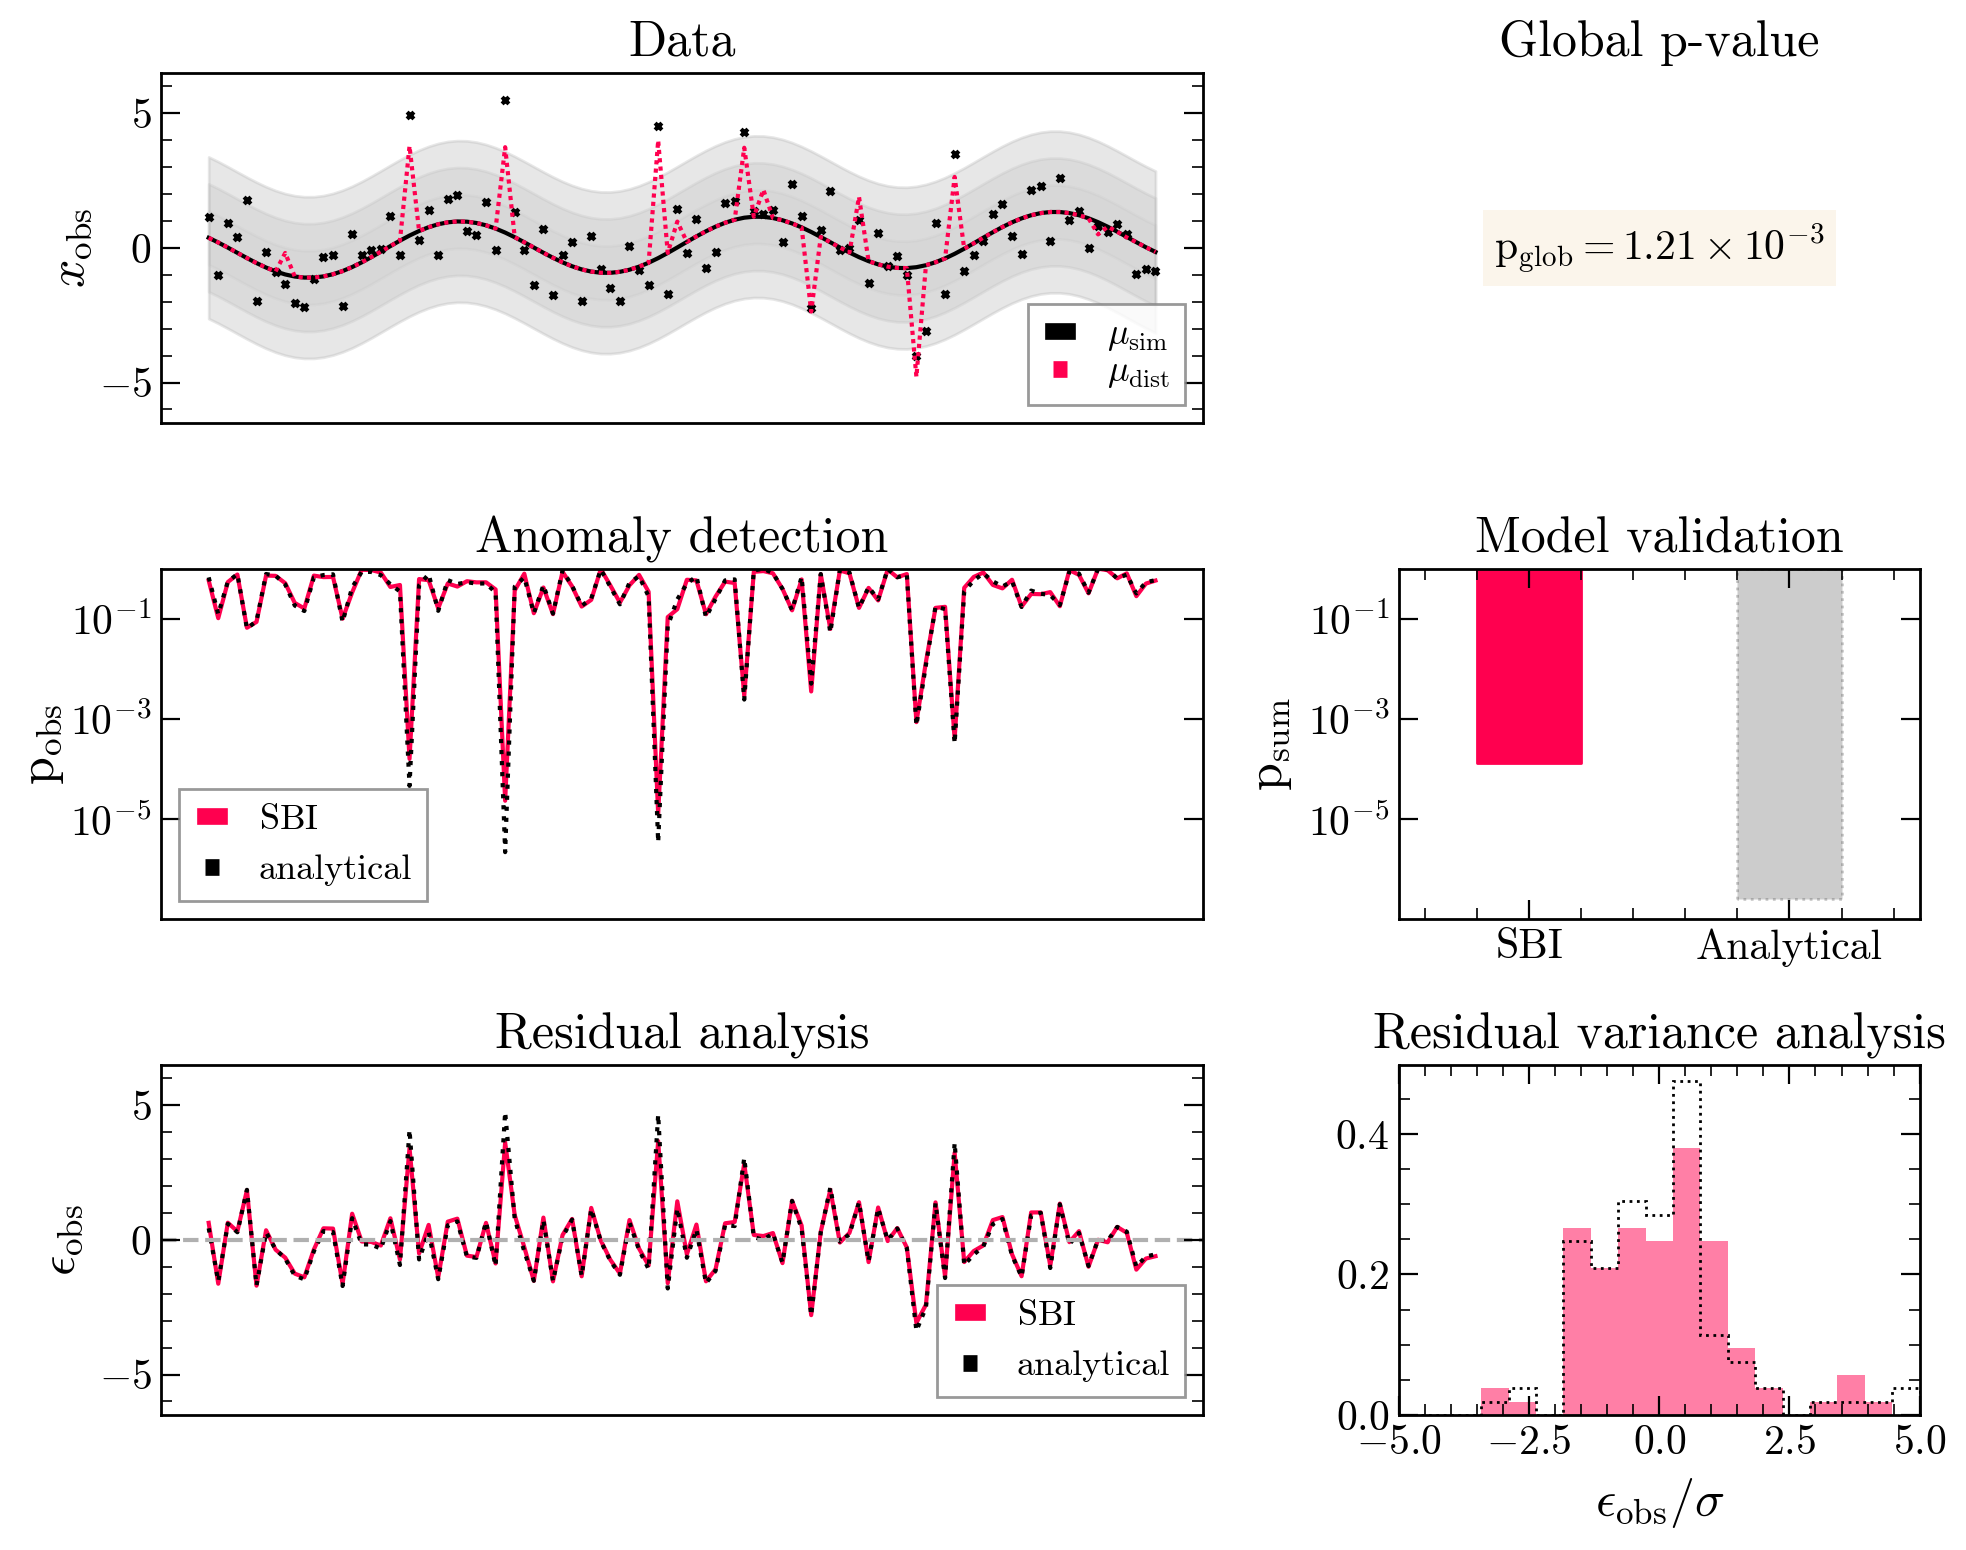

In [116]:
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=True, bounds=bounds, fraction=0.1, dtype=torch.float32)     
obs = simulator1.sample(1) 

epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all = analyse_obs_epsilon(obs)
plot_analysis_epsilon(obs, epsilon_nn, epsilon_analytical, variance_nn, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all)

p_sum_nn, p_sum_analytical

# Part B: Training BCE

Now that we've had a go at doing SBI, let's see how it compares when we train BCE versus training signal-to-noise - this way we can check whether our assumption that training SNR over directly traning BCE is a good assumption. We'll start by creating a separate network and training it on the same basis that we trained epsilon (for SNR)

In [117]:
from models.online_norm import OnlineStandardizingLayer
from models.unet_1d import UNet1d 
from models.resnet_1d import ResidualNet


class Network_BCE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.net = UNet1d(1, 1, sizes=(8, 16, 32, 64, 128))
        # self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 
        self.online_norm = OnlineStandardizingLayer((Nbins,), use_average_std=False) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


**Now, as before, let's train the network.**

In [121]:
def resample(sample):
    sample = simulator._resample(sample)
    sample['x'] = sample['xi']    
    for k, v in sample.items():
        if v.ndim > 1:
            sample[k] = v.squeeze(0)
    return sample

batch_size = 128
samples = simulator.sample(Nsims=Nsims)  
dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
# dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size)
network_BCE = Network_BCE().to(dtype=torch.float32, device='mps')
model = BCELossModule(network_BCE, learning_rate=8e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=20, 
    precision=32,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_BCE.to(dtype=torch.float32, device='mps').eval();

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | Network_BCE | 181 K  | train
----------------------------------------------
181 K     Trainable params
0         Non-trainable params
181 K     Total params
0.725     Total estimated model params size (MB)
99        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Reloading best model: /Users/thardy/Documents/cambridge/gw-mist/notebooks/week2/lightning_logs/version_22/checkpoints/epoch=17-val_loss=0.48.ckpt


## Evaluating the BCE Model
We start by defining a NLL test statistic, and our individual ts follows $t_i(\mathbf x) \propto \text{SNR}_i^2(\mathbf x)$ on the $H_0$. We'll follow the same process of generating a large MC sample and following the statistics. Start by defining this test statistic TS where

\begin{equation}
TS(x) = - 2 \log\frac{\mathbb{P}(x|H_0)}{\mathbb{P}(x|H_1)}
\end{equation}

In [132]:
def dict_to_mps(x):
    if isinstance(x, dict):
        return {k: dict_to_mps(v) for k, v in x.items()}
    elif isinstance(x, torch.Tensor):
        return x.to(device='mps')
    elif isinstance(x, list):
        return [dict_to_mps(item) for item in x]
    else:
        return x

def dict_to_cpu(x: dict) -> dict:
    out = {}
    for key, val in x.items():
        if isinstance(val, torch.Tensor):
            out[key] = val.to(device='cpu')
        else:
            out[key] = val
    return out


def ts_sbi(x: dict, model: int =0):
    # x = dict_to_double(x)
    x = dict_to_mps(x)
    
    # Test statistic for sample 0 or 1
    if 'x' not in x.keys():
        if model == 0:
            x['x'] = x['x0']
        elif model == 1:
            x['x'] = x['xi'] 

    # Test statistic
    t = 2 * (network_BCE(x).detach().cpu().squeeze(0).numpy())
    
    # Go back to cpu 
    x = dict_to_cpu(x)
    return t

Now we generate our MC sample, which has $2\times10^6$ items and a batch size of $2^{12}$

In [135]:
N_mc = 2e6

batch_size = 2048*2
N_batch = int(N_mc / batch_size)
ts_bin_H0_BCE = []
for _ in range(N_batch):
    mc_samples = simulator.sample(batch_size)
    ts_bin_H0_BCE.append(ts_sbi(mc_samples, model=0))
ts_bin_H0_BCE = np.concatenate(ts_bin_H0_BCE)

ts_bin_H0_BCE.shape

(1998848, 100)

As before, let's compare the distribution of the test statistic with the $\chi^2$ df=1 (remember that this just arises when we sample from the log likelihood of a gaussian - covered with James in-person 9th July. We'll start with a histogram of $t_i|H_0$ on individual bins. Note the bump discontinuity we get around zero - this'll manifest as a knee in log-space

<>:15: SyntaxWarning: invalid escape sequence '\c'
<>:15: SyntaxWarning: invalid escape sequence '\c'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/2312599830.py:15: SyntaxWarning: invalid escape sequence '\c'
  axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')


True

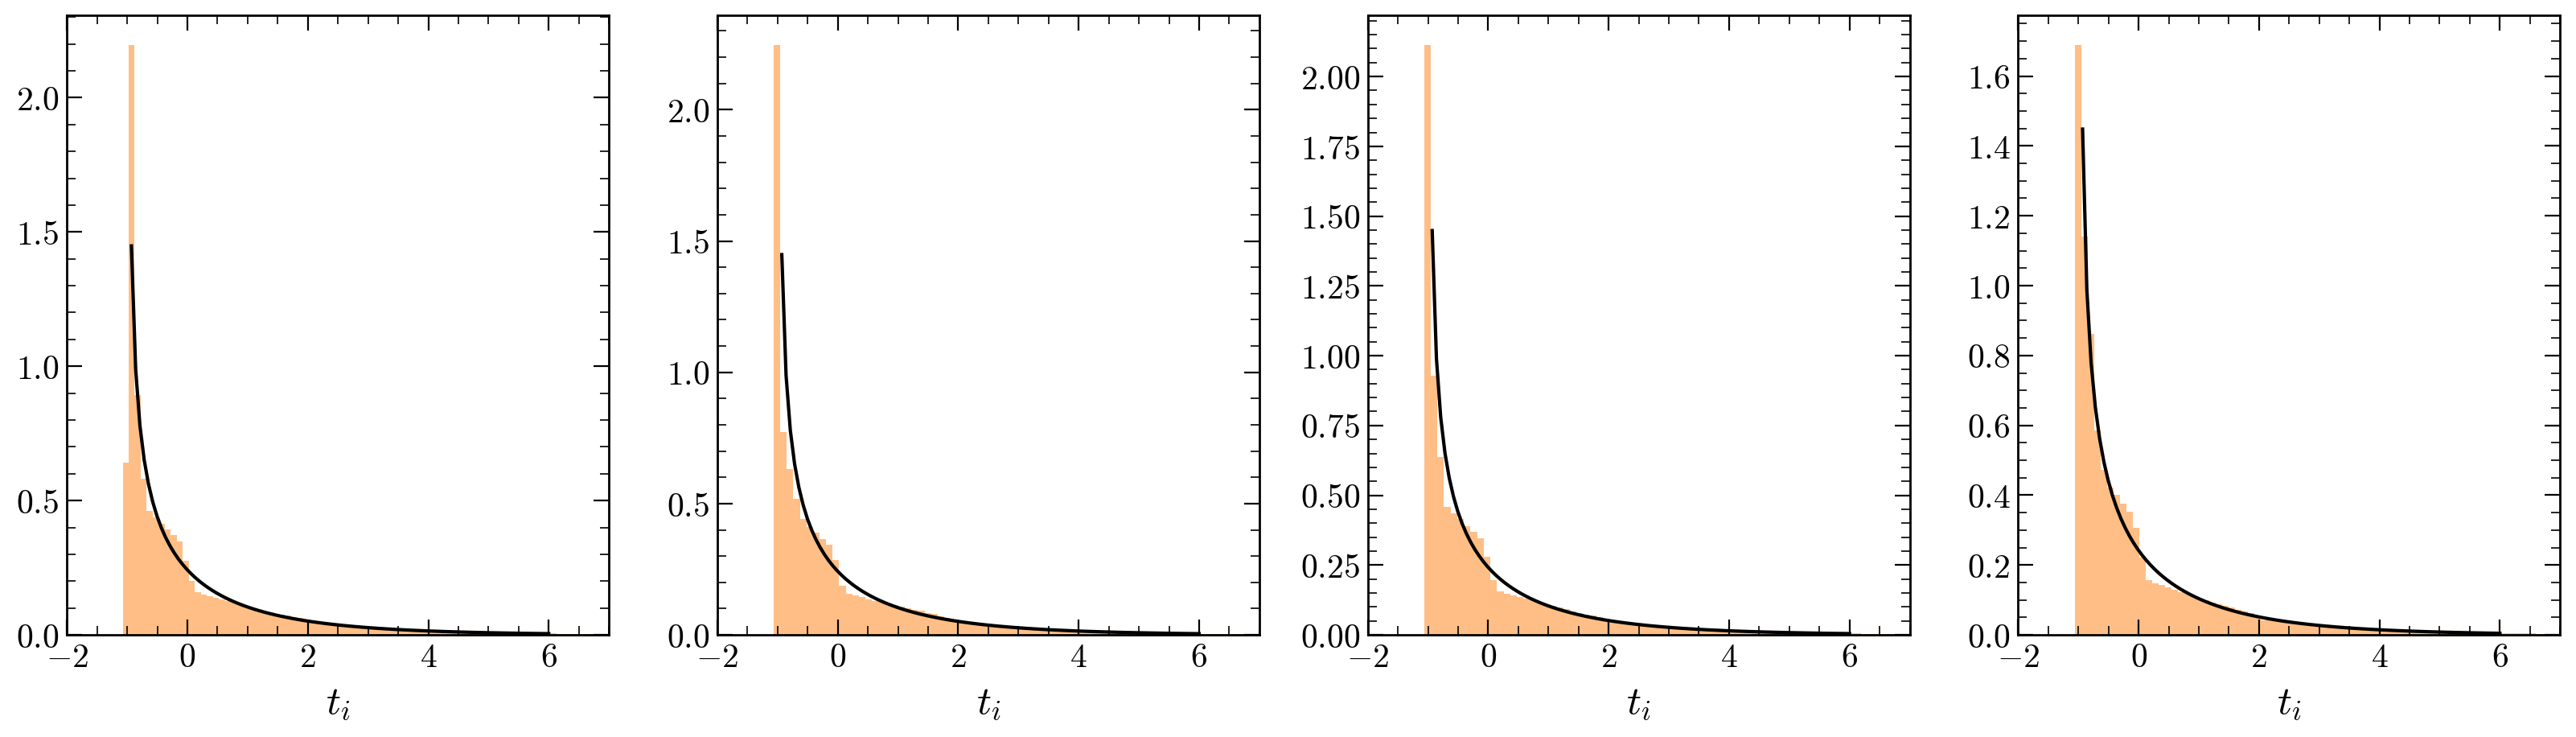

In [139]:
# Compare with chi2 with df = 1
grid = np.linspace(-1, 6, 100) # 1 df, adjust
chi2 = scipy.stats.chi2.pdf(grid, df=1, loc=-1)

fig, axs = plt.subplots(1, 4, figsize=(20, 5), dpi=200)
for i in range(4):
    bin = torch.randint(Nbins, (1,))
    ts_bin_i = ts_bin_H0_BCE[:, bin]
    m = ts_bin_i.mean()

    bins = np.linspace(0, 10, 100)
    axs[i].hist(ts_bin_i-m, bins=200, density=True, color='C1', alpha=0.5)    
    axs[i].set_xlabel('$t_i$')
    axs[i].set_xlim(-2, 7)
    axs[i].plot(grid, chi2, c='k', label='$\chi^2$ with df=1')

pf.fix_plot(axs)

And similarly to before, let's see how the model copes with predicting some individual distortions by plotting some individual samples from our MC stuff.

<>:51: SyntaxWarning: invalid escape sequence '\m'
<>:51: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/1611431528.py:51: SyntaxWarning: invalid escape sequence '\m'
  axs[2, 0].set_ylabel("$\mathrm{p}_i$")


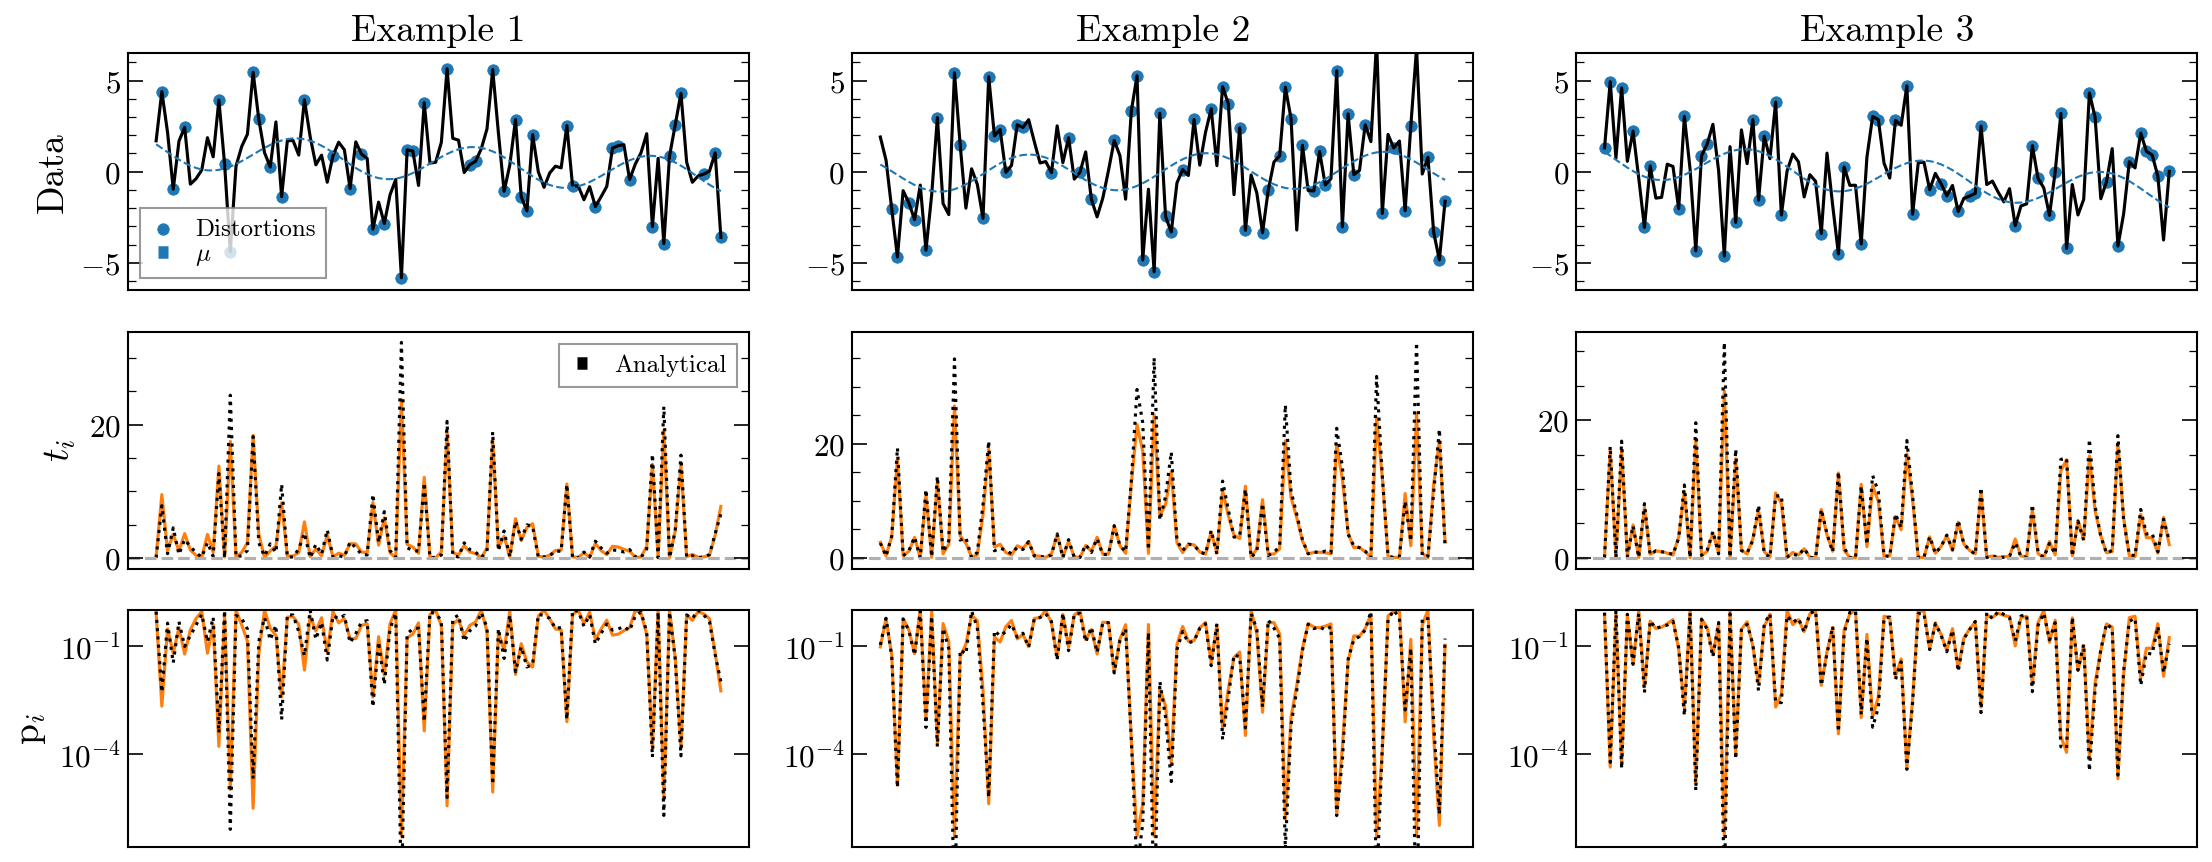

In [142]:
fig, axs = plt.subplots(3, 3, figsize=(15, 6), dpi=150)
for i in range(3):
    
    # Get sample
    obs = simulator.sample(1) 
    ts_bin_obs = ts_sbi(obs, model=1)
    ts_bin_analytical = (((obs['xi']- best_fit(obs['xi'][0], simulator))**2)/SIGMA**2)[0]-1

    # Compute p-values
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(ts_bin_obs):
        ts_bin_i = ts_bin_H0_BCE[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))  
        _p_analytical.append(t_to_pvalue(ts_bin_analytical[idx] + 1, 1)) # 1 Nbins per bin
    p_nn = np.array(_p_nn) 
    p_analytical = np.array(_p_analytical)   
    
    # Plotting
    x = obs['xi'][0]
    ni = obs['ni'][0] 
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    axs[0, i].set_xticks([])

    axs[1, i].plot(grid,  ts_bin_obs-ts_bin_obs.min(), c='C1')
    axs[1, i].plot(grid, ts_bin_analytical - ts_bin_analytical.min(), c='k', ls='dotted', label='Analytical')
    axs[1, i].axhline(0, color='#b0b0b0', linestyle='--')
    axs[1, i].set_xticks([])

    axs[2, i].semilogy(grid, p_nn, c='C1')
    axs[2, i].semilogy(grid, p_analytical, c='k', ls='dotted', label='Analytical')
    axs[2, i].set_ylim(1/N_mc/2, 1)
    axs[2, i].grid(True, axis='y')
    axs[2, i].set_xticks([])
    
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel(r"$t_i$")
axs[1, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[2, 0].set_ylabel("$\mathrm{p}_i$")

for ax in axs:
    pf.fix_plot(ax)
plt.tight_layout();


As before, let's agregate the test statistic. Same as last time we'll use $t_{\rm sum}(x) = \sum_{i=1}^{N_{\rm alt}} - 2 \log\frac{p(x|H_0)}{p(x|H_i)} $. We notice that this is a lot more accurate around zero than our S/N trained method.

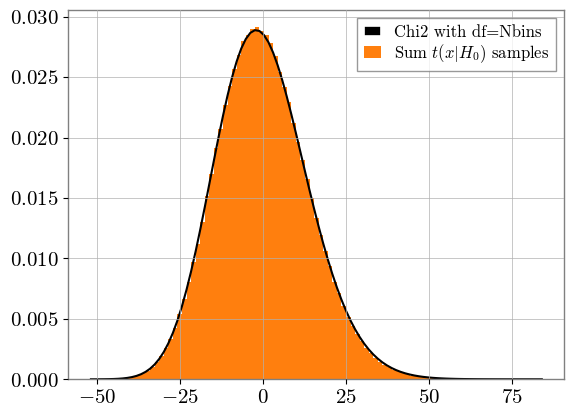

In [144]:
DOF = Nbins - 3 # 3 parameters

# From MCMC samples
ts_sum_H0_BCE = ts_bin_H0_BCE.sum(axis=1)
ts_sum_H0_BCE_mean = ts_sum_H0_BCE.mean()
ts_sum_H0_BCE = ts_sum_H0_BCE - ts_sum_H0_BCE_mean

# Plot
plt.figure()
bins = np.linspace(ts_sum_H0_BCE.min(), ts_sum_H0_BCE.max(), 100)
plt.plot(bins, scipy.stats.chi2.pdf(bins, df=DOF, loc=-DOF), c='k', label='Chi2 with df=Nbins')
plt.hist(ts_sum_H0_BCE, bins=bins, density=True, color='C1', label='Sum $t(x|H_0)$ samples')
plt.legend(loc='best', fontsize=12, labelspacing=0.1);

Let's test the summed p-value for some specific samples too and see how the network compares the the analytical version:

<>:41: SyntaxWarning: invalid escape sequence '\m'
<>:41: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/197488109.py:41: SyntaxWarning: invalid escape sequence '\m'
  axs[1, 0].set_ylabel("$\mathrm{p}_\mathrm{sum}$")


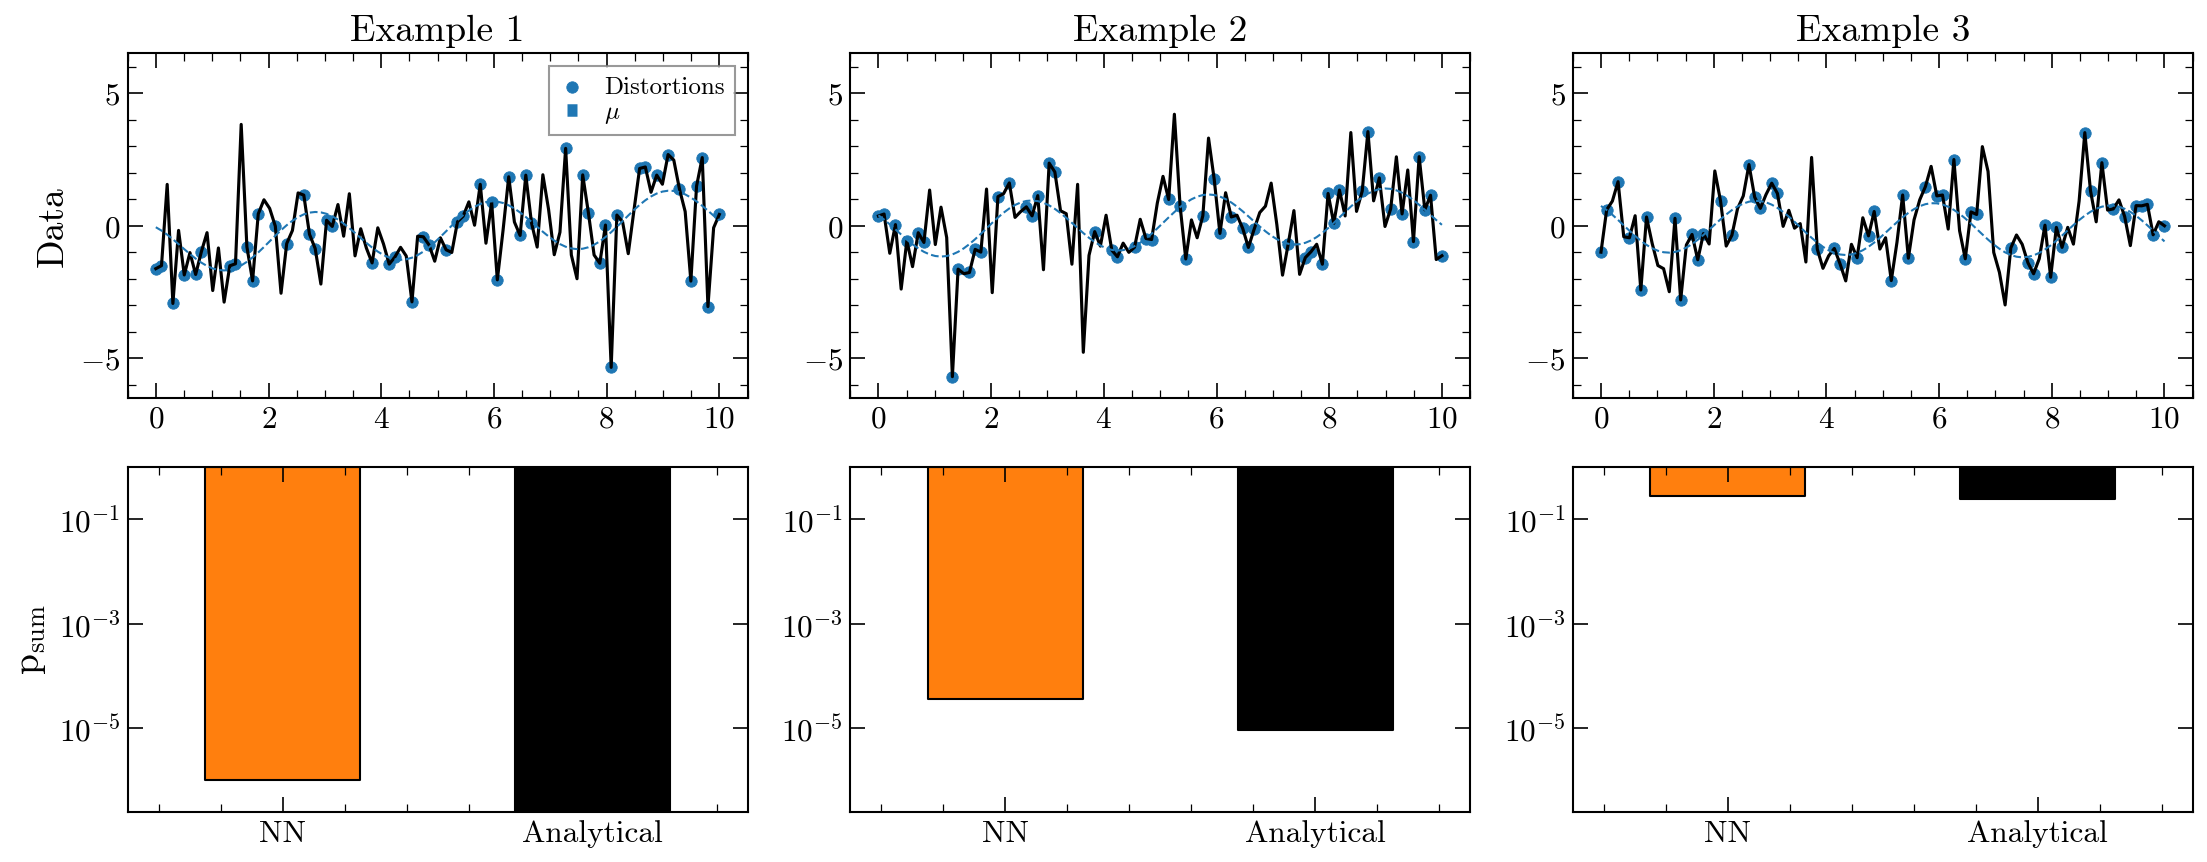

In [151]:
fig, axs = plt.subplots(2, 3, figsize=(15, 6), dpi=150)
for i in range(3):
    
    # Get sample
    obs = simulator.sample(1) 
    simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=True, bounds=bounds, fraction=0.1, dtype=torch.float32)     
    obs = simulator1.sample(1) 
    
    ts_bin_obs = ts_sbi(obs, model=1)
    ts_sum_obs = ts_bin_obs.sum()-ts_sum_H0_BCE_mean
    p_obs = t_to_pvalue_empirical(ts_sum_obs, ts_sum_H0_BCE)
    p_sum_nn = t_to_pvalue_empirical(ts_sum_obs, ts_sum_H0_BCE) 
    ts_sum_obs_analytical = (((obs['xi']- best_fit(obs['xi'][0], simulator))**2)/SIGMA**2).sum()-DOF
    p_sum_analytical = t_to_pvalue(ts_sum_obs_analytical+DOF, DOF) 
    
    # Plotting
    x = obs['xi'][0]
    grid = torch.linspace(0, 10, len(x))
    
    axs[0, i].plot(grid, obs['xi'][0], c='k')
    axs[0, i].scatter(grid[ni!=0], y=x[ni!=0], c='C0', s=30, marker='o',linewidths=0.4)
    axs[0, i].plot(grid, obs['mu'][0], c='C0', ls='--', lw=1)
    axs[0, i].set_title(f"Example {i+1}")
    axs[0, i].set_ylim(-6.5, 6.5)
    
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim(1/(N_mc*2), 1)
    axs[1, i].set_xticks([0, 1])
    axs[1, i].set_xticklabels(['NN', 'Analytical'])
    axs[1, i].set_xlim(-0.5, 2 - 0.5)
    axs[1, i].grid(True)
    for x, value, color in zip([0, 1], [p_sum_nn, p_sum_analytical], ['C1', 'k']):
        left = x - 0.5 / 2
        right = x + 0.5 / 2
        axs[1, i].fill_between([left, right], 1, value, facecolor=color, edgecolor='black')
    
axs[0, 0].scatter([],[], c='C0', s=30, marker='o',linewidths=0.4, label='Distortions')
axs[0, 0].plot([],[], c='C0', ls='--', lw=1, label=r'$\mu$')
axs[0, 0].legend(loc='best', fontsize=12, labelspacing=0.1)
axs[0, 0].set_ylabel("Data")
axs[1, 0].set_ylabel("$\mathrm{p}_\mathrm{sum}$")

for ax in axs:  
    pf.fix_plot(ax)

plt.tight_layout();

Like before, let's see what the global deviations tests look for. We're asking what the overall significance is, given that we've looked a certain number of times (2e6). Remember that each trial is one test. let's start by computing the P-values for the individual test, binning them and ranking as before. We'll plot some random bins to check that the distribution is uniform, and similarly plot to double check the correlation between independent bins.

In [155]:
### - START BY CALCULATING BINWISE PVALUES - ### (this cell takes a second)
N_mc, num_bins = ts_bin_H0_BCE.shape
ts_bin_flat = ts_bin_H0_BCE.reshape(N_mc, num_bins)
means = ts_bin_flat.mean(axis=0)  # Shape: [num_bins]
ts_centered = ts_bin_flat - means  # Shape: [N_mc, num_bins]

sorted_ts = np.sort(ts_centered, axis=0)  # Shape: [N_mc, num_bins]
ranks = np.argsort(np.argsort(-ts_centered, axis=0), axis=0)  # Ranks in descending order
p_values = (ranks + 1) / N_mc
pv_bin_H0 = p_values.reshape(N_mc, num_bins)    

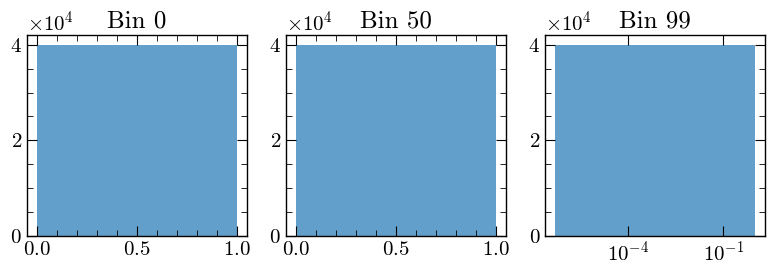

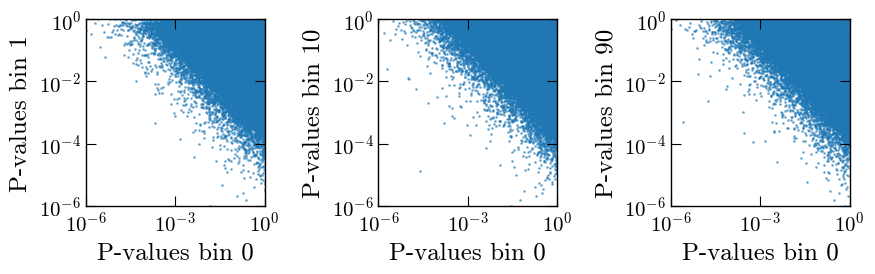

In [160]:
### -  PLOT SOME INDIVIDUAL BINS - ###
selected_bins = [0, 50, 99]            # Bins to plot
fig, axs = plt.subplots(1, len(selected_bins), figsize=(8, 3))
for j, bin_idx in enumerate(selected_bins):
    pv_data = pv_bin_H0[:, bin_idx]
    axs[j].hist(pv_data, bins=50, alpha=0.7)
    axs[j].set_title(f'Bin {bin_idx}')
    axs[i].set_xscale('log')
pf.fix_plot(axs)

plt.tight_layout()
plt.show()

### - NOW PLOT SOME PAIRS OF BINS - ###
bins_pairs = [(0, 1), (0, 10), (0, 90)]

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for i, (bin1, bin2) in enumerate(bins_pairs):
    p_values_res1 = pv_bin_H0[:, bin1]
    p_values_res2 = pv_bin_H0[:, bin2]

    axs[i].scatter(p_values_res1, p_values_res2, alpha=0.5, s=1)
    axs[i].set_xlabel(f'P-values bin {bin1}')
    axs[i].set_ylabel(f'P-values bin {bin2}')
    axs[i].set_xlim(1e-6, 1)
    axs[i].set_ylim(1e-6, 1)
    axs[i].set_xscale('log')
    axs[i].set_yscale('log')
    axs[i].grid(True)
pf.fix_plot(axs)
    
plt.tight_layout()
plt.show()


And as before, let's test globally across the sample too...

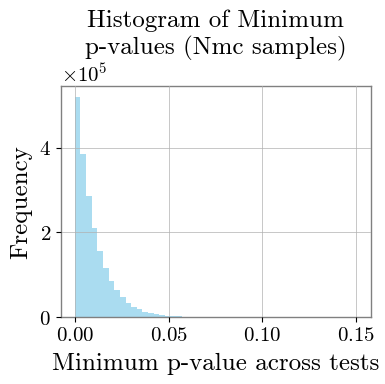

In [163]:
Nmc = pv_bin_H0.shape[0]
min_pv_bin_H0_BCE = np.min(pv_bin_H0.reshape(Nmc, -1), axis=1)  # Shape: [Nmc]

plt.figure(figsize=(4, 3))
plt.hist(min_pv_bin_H0_BCE, bins=50, alpha=0.7, color='skyblue')
plt.xlabel('Minimum p-value across tests')
plt.ylabel('Frequency')
plt.title('Histogram of Minimum\np-values (Nmc samples)')
plt.grid(True)
plt.show()


(1998848, 101)


True

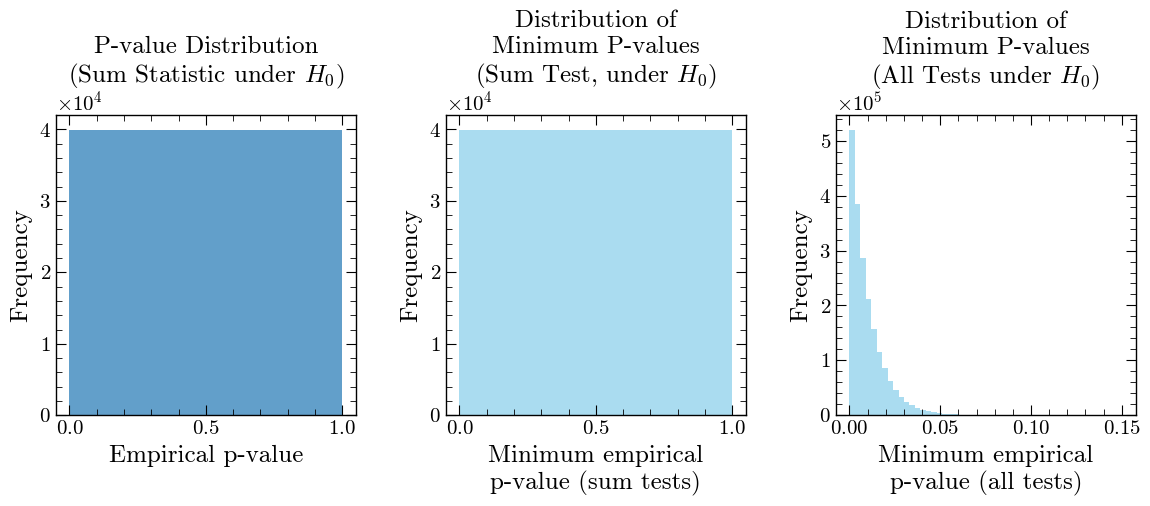

In [164]:
### - CENTER AND RANK TS_SUM UNDER H0 - ###
# Center the test statistic (e.g., chi-squared-like) under H0 by subtracting the mean
means = ts_sum_H0_BCE.mean(axis=0)  # Mean of summed test statistic across MC samples
ts_centered = ts_sum_H0_BCE - means  # Centered statistic

# Sort and rank the centered values to compute empirical p-values
sorted_ts = np.sort(ts_centered, axis=0)
ranks = np.argsort(np.argsort(-ts_centered, axis=0))  # Descending ranks
p_values = (ranks + 1) / N_mc  # Empirical p-values

pv_sum_H0 = p_values  # Final p-values for the sum test
pv_sum_H0.shape  # Check shape, should be (N_mc,)

### - PLOT HISTOGRAM OF EMPIRICAL P-VALUES - ###
fig,ax1=pf.create_plot(size=(3,3))
ax1.hist(pv_sum_H0, bins=50, alpha=0.7)
ax1.set_xlabel('Empirical p-value')
ax1.set_ylabel('Frequency')
ax1.set_title("P-value Distribution\n"+r"(Sum Statistic under $H_0$)")

# This shows the distribution of the p-values under H0 for the sum test

############### THIS COULD BE A MISTAKE REPEAT PLOT ######################
### - PLOT MINIMUM P-VALUES FROM SUM TEST - ###
min_pv_sum_H0_BCE = np.min(pv_sum_H0.reshape(Nmc, -1), axis=1)

ax2 = fig.add_axes((1.3,0,1,1))
ax2.hist(min_pv_sum_H0_epsilon, bins=50, alpha=0.7, color='skyblue')
ax2.set_xlabel('Minimum empirical\np-value (sum tests)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of\nMinimum P-values\n'+r'(Sum Test, under $H_0$)')
#########################################################################

### - COMBINE BIN-WISE AND SUM P-VALUES - ###
Nmc = pv_bin_H0.shape[0]
pv_all_H0 = np.concatenate([
    pv_bin_H0.reshape(Nmc, -1),     # Bin-wise p-values
    pv_sum_H0.reshape(Nmc, -1)      # Sum p-values
], axis=1)  # Combined shape: [N_mc, N_bins + 1]

print(pv_all_H0.shape)  # Sanity check

### - PLOT MINIMUM P-VALUES ACROSS ALL TESTS - ###
min_pv_all_H0_BCE = np.min(pv_all_H0, axis=1)  # Take minimum p-value across all bins + sum

ax3 = fig.add_axes((2.6,0,1,1))
ax3.hist(min_pv_all_H0_BCE, bins=50, alpha=0.7, color='skyblue')
ax3.set_xlabel('Minimum empirical\np-value (all tests)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of\nMinimum P-values\n'+'(All Tests under $H_0$)')

pf.fix_plot([ax1,ax2,ax3])

## Creating a summary plot for the BCE Model....

In [165]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cycler import cycler

mygold = (218/255, 165/255, 64/255, 0.1)  

def cax(ax, pad=0.05):
    divider = make_axes_locatable(ax)
    return divider.append_axes(position='top', size='5%', pad=pad)

In [174]:
def analyse_obs_BCE(obs):
    
    target = obs['xi']
    
    ts_bin_obs = ts_sbi(obs, model=1)
    ts_bin_analytical = (((obs['xi']- best_fit(obs['xi'][0], simulator))**2)/SIGMA**2)[0]-1
    ts_sum_obs = ts_bin_obs.sum()-ts_sum_H0_BCE_mean
    ts_sum_obs_analytical = (((obs['xi']- best_fit(obs['xi'][0], simulator))**2)/SIGMA**2).sum()-DOF
    _p_nn, _p_analytical = [], []
    for idx, ts_bin in enumerate(ts_bin_obs):
        ts_bin_i = ts_bin_H0_BCE[:, idx]
        m = ts_bin_i.mean()
        ts0_ref = ts_bin_i - m
        ts_obs = (ts_bin-m)
        _p_nn.append(t_to_pvalue_empirical(ts_obs, ts0_ref))
        _p_analytical.append(t_to_pvalue(ts_bin_analytical[idx]+1, 1))
    p_nn = np.array(_p_nn)
    p_analytical = np.array(_p_analytical)
    p_sum_nn = t_to_pvalue_empirical(ts_sum_obs, ts_sum_H0_BCE)   
    p_sum_analytical = t_to_pvalue(ts_sum_obs_analytical+DOF, DOF)

    # Compute global p-values
    obs_min_pv_bin = p_nn.reshape(-1).min()
    obs_min_pv_sum = p_sum_nn
    pv_all_obs = np.concatenate([
        p_nn.reshape(-1),  # Shape: [Nbins]
        torch.tensor([p_sum_nn])  # Shape: [1]
    ], axis=0)  # Combined shape: [num_total_tests]
    obs_min_pv_all = pv_all_obs.min()

    p_glob_bin = np.mean(min_pv_bin_H0_BCE <= obs_min_pv_bin)
    p_glob_all = np.mean(min_pv_all_H0_BCE <= obs_min_pv_all)

    p_glob_bin, p_glob_all

    return ts_bin_obs, ts_bin_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all


def plot_analysis_BCE(obs, ts_bin_obs, ts_bin_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all):
    
    # Figure
    fig = plt.figure(figsize=(10, 8), dpi=200)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

    ### FIRST PART
    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    ni = obs['ni'][0] 
    dist = obs['xi'][0] - obs['x0'][0]
    grid = torch.linspace(0, Nbins, Nbins)
    ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
    ax1.fill_between(grid, obs['mu'][0]-1, obs['mu'][0]+1,  color='#b0b0b0', alpha=0.1)
    ax1.fill_between(grid, obs['mu'][0]-2, obs['mu'][0]+2,  color='#b0b0b0', alpha=0.2)
    ax1.fill_between(grid, obs['mu'][0]-3, obs['mu'][0]+3,  color='#b0b0b0', alpha=0.3)
    ax1.scatter(grid, xi, c='k', marker='x', s=6)
    ax1.plot(grid, obs['mu'][0]+dist, color=mycolors[1], label="$\mu_{\mathrm{dist}}$")
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.legend(fontsize=13, loc='best', labelspacing=0.1)
    ax1.set_ylim(-6.5, 6.5)
    ax1.set_xticks([])
    ax1.set_title("Data")

    # Second column: ax2 and ax3 in the first column
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn, c=mycolors[1], label=r"$\mathrm{SBI}$")
    ax2.semilogy(grid, p_analytical, c='k', ls='dotted', label=r"analytical")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.legend(loc='best',  fontsize=13)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.grid(True)

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.plot(grid, ts_bin_obs-ts_bin_obs.min(), c=mycolors[1], label=r"$\mathrm{SBI}$")
    ax3.plot(grid, ts_bin_analytical - ts_bin_analytical.min(), c='k', ls='dotted',label=r"analytical")
    ax3.set_ylabel(r"$t_\mathrm{obs}$")
    ax3.legend(loc='best',  fontsize=13)
    ax3.set_ylim(-.1, None)
    ax3.set_xticks([])
    ax3.set_title("")
    ax3.axhline(0, color='#b0b0b0', linestyle='--')


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1])
    ax4.set_xticklabels(["SBI", "Analytical"])
    ax4.set_xlim(-0.5, 2 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn, facecolor=mycolors[1], edgecolor=mycolors[1])
    ax4.fill_between([0.8, 1.2], 1, p_sum_analytical, alpha=0.2, edgecolor='k', facecolor='k', linestyle = 'dotted')
    ax4.set_title("Model validation")
    ax4.grid(True, axis='y')

    
    # Add on gs[0, 1] text reporting the three global p-values
    ax_text = fig.add_subplot(gs[0, 1])
    mantissa, exp = ('%.2e' % p_glob_all).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.5, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax_text.axis('off')
    ax_text.set_title("Global p-value")
    pf.fix_plot([ax1,ax2,ax3,ax4])

    plt.tight_layout();

<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:95: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:57: SyntaxWarning: invalid escape sequence '\m'
<>:58: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:95: SyntaxWarning: invalid escape sequence '\m'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/2766329176.py:52: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/2766329176.py:57: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(grid, obs['mu'][0]+dist, color=mycolors[1], label="$\mu_{\mathrm{dist}}$")
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/2766329176.py

np.True_

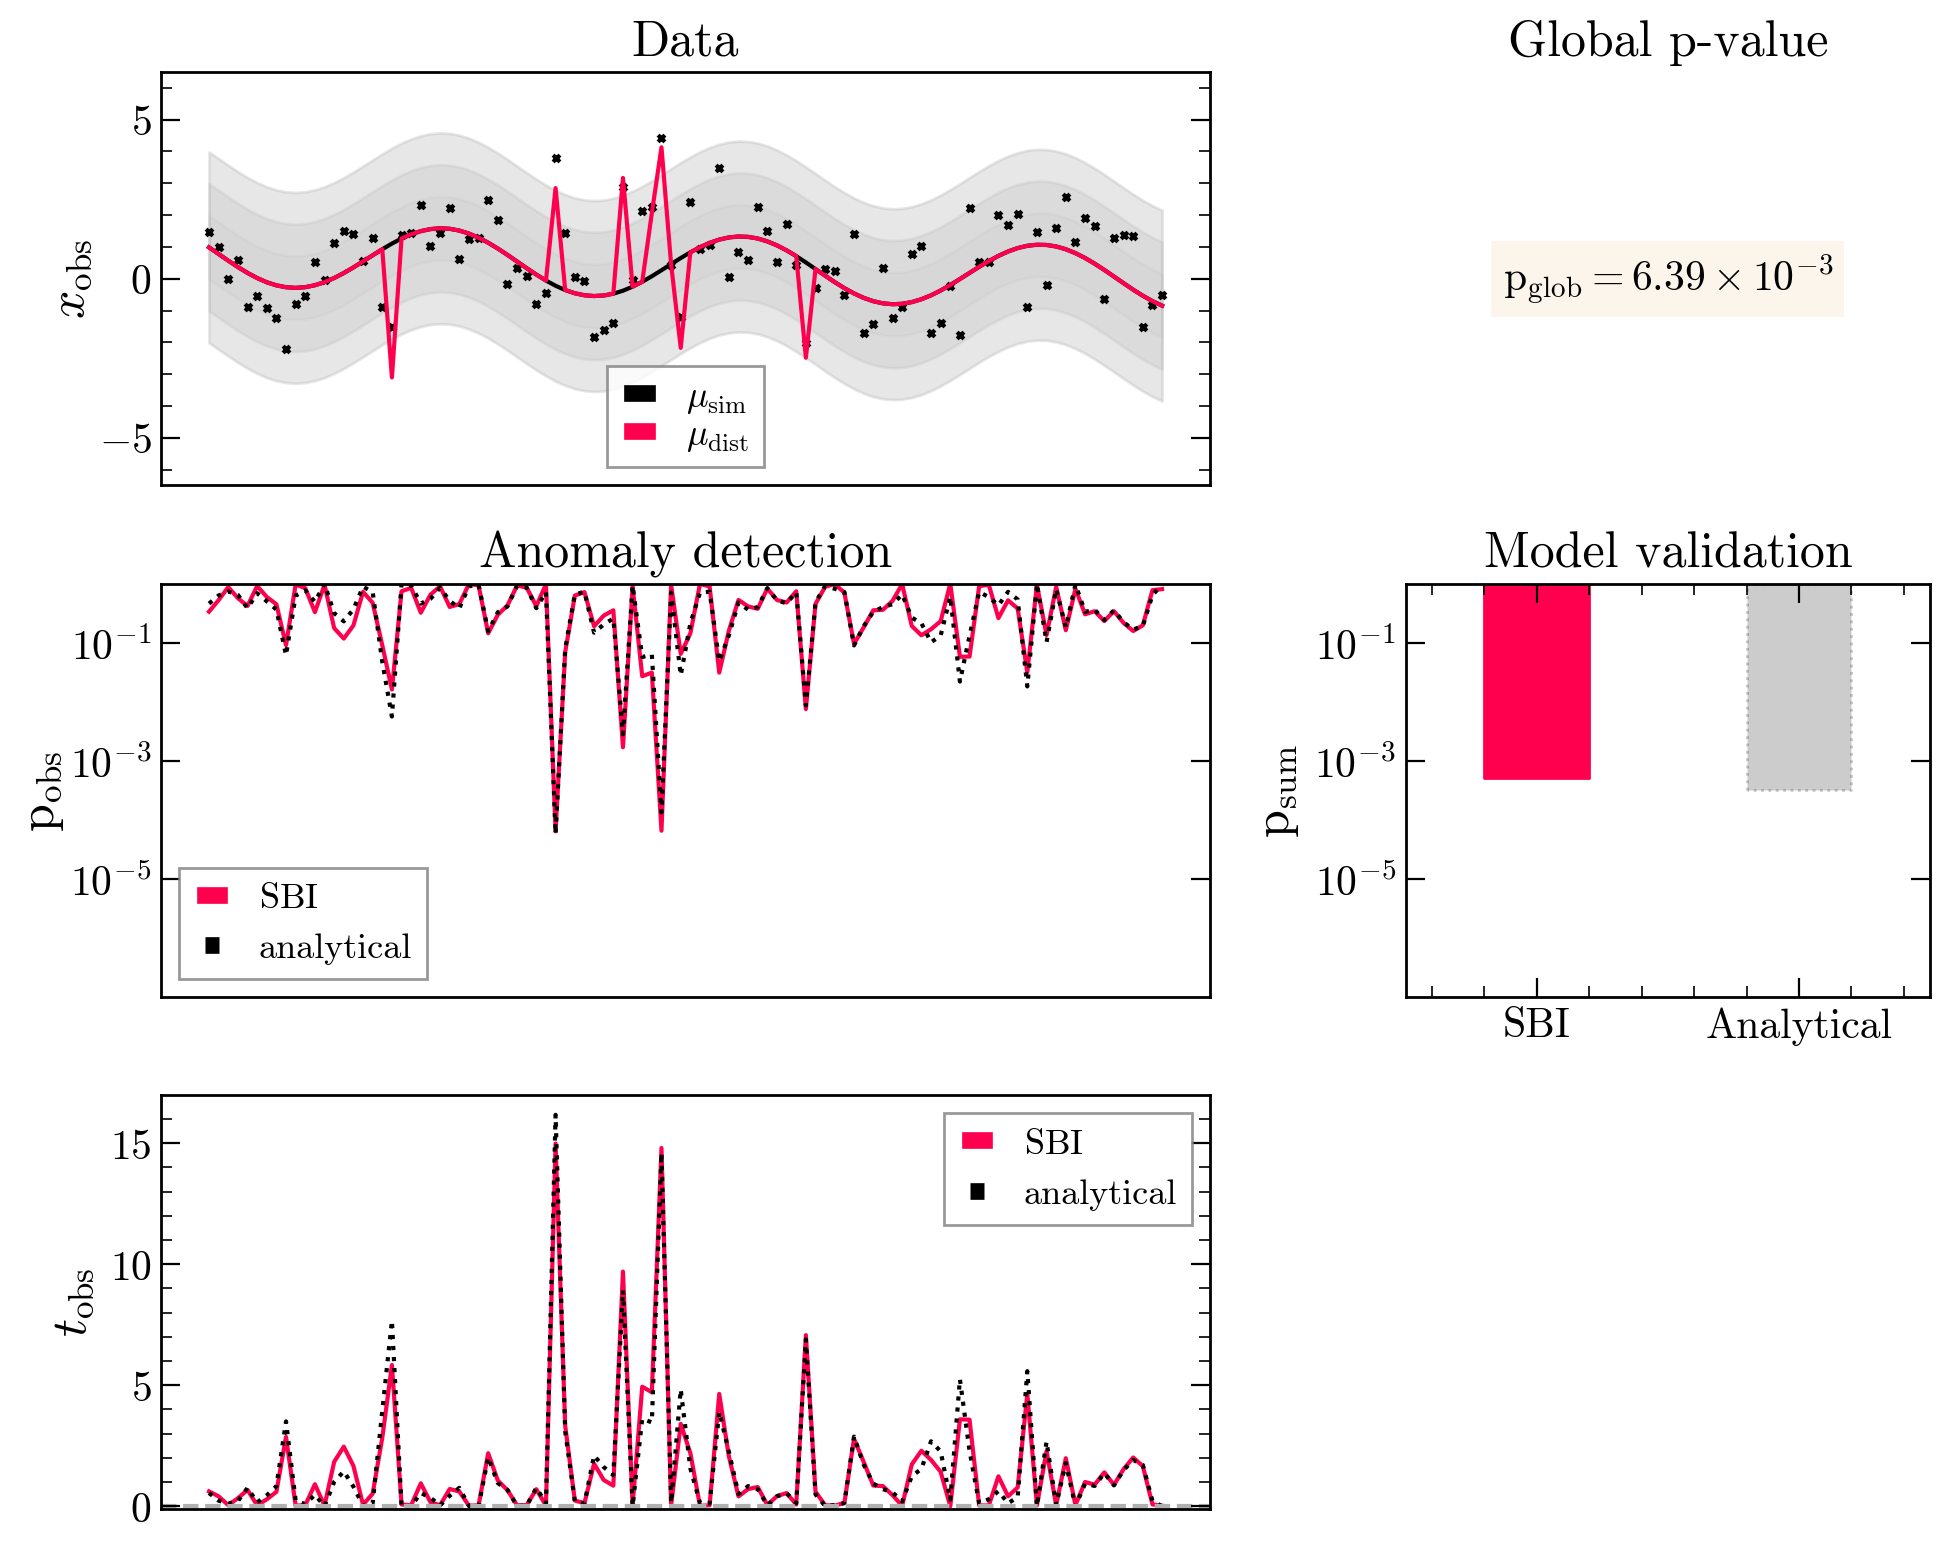

In [187]:
# OBS
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=True, bounds=bounds, fraction=0.05, dtype=torch.float32)     # Just one bin is distorted with fraction=None  
obs = simulator1.sample(1) 

ts_bin_obs, ts_bin_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all = analyse_obs_BCE(obs)
plot_analysis_BCE(obs, ts_bin_obs, ts_bin_analytical, p_nn, p_analytical, p_sum_nn, p_sum_analytical, p_glob_all)

p_sum_nn > p_sum_analytical

# Combining
Finally, we'll write some code to combine it all together in one plot, and run some examples to see whether the stats agree

In [182]:
def plot_together(
    obs, 
    ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE,
    snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon
    ):
    
    fig = plt.figure(figsize=(10, 8), dpi=200)
    gs = plt.GridSpec(3, 2, figure=fig, height_ratios=[1, 1, 1], width_ratios=[2, 1])

    ### FIRST PART
    # First row: ax1 spans both columns
    ax1 = fig.add_subplot(gs[0, 0])
    xi = obs['xi'][0]
    ni = obs['ni'][0] 
    dist = obs['xi'][0] - obs['x0'][0]
    grid = torch.linspace(0, Nbins, Nbins)
    ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
    ax1.fill_between(grid, obs['mu'][0]-1, obs['mu'][0]+1,  color='#b0b0b0', alpha=0.1)
    ax1.fill_between(grid, obs['mu'][0]-2, obs['mu'][0]+2,  color='#b0b0b0', alpha=0.2)
    ax1.fill_between(grid, obs['mu'][0]-3, obs['mu'][0]+3,  color='#b0b0b0', alpha=0.3)
    ax1.scatter(grid, xi, c='k', marker='x', s=6)
    ax1.plot(grid, obs['mu'][0]+dist, color=mycolors[0], label="$\mu_{\mathrm{dist}}$")
    ax1.set_ylabel("$x_\mathrm{obs}$", labelpad=1.5)
    ax1.legend(bbox_to_anchor=(0.05, 1), fontsize=13, loc='upper left', labelspacing=0.1)
    ax1.set_ylim(-6.5, 6.5)
    ax1.set_xticks([])
    ax1.set_title("Data")

    # Second column: ax2 and ax3 in the first column
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.semilogy(grid, p_nn_BCE, c=mycolors[1], label=r"$\mathrm{BCE}$")
    ax2.semilogy(grid, p_nn_epsilon, c=mycolors[2], label=r"$\mathrm{SNR}$")
    ax2.semilogy(grid, p_analytical_BCE, c='k', ls='dotted', label=r"Analytical")
    # ax2.semilogy(grid, p_analytical_epsilon, c='blue', ls='dotted', label=r"analytical")
    ax2.set_ylabel("$\mathrm{p}_\mathrm{obs}$", labelpad=1.5)
    ax2.set_ylim(1/(N_mc*5), 1)
    ax2.set_xticks([])
    ax2.set_title("Anomaly detection")
    ax2.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax2.yaxis.set_minor_locator(ticker.NullLocator())
    ax2.grid(True, axis='y', which='major')
    ax2.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax2.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels
    # ax2.legend(loc='best', fontsize=13, frameon=True, facecolor='white', framealpha=1, fancybox=True, edgecolor='white')

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.plot(grid, ts_bin_obs-ts_bin_obs.min(), c=mycolors[1], label=r"$\mathrm{BCE}$")
    ax3.plot(grid, snr2_nn-snr2_nn.min(), c=mycolors[2], label=r"$\mathrm{SNR}$")
    ax3.plot(grid, ts_bin_analytical - ts_bin_analytical.min(), c='k', ls='dotted',label=r"Analytical")
    # ax3.plot(grid, snr2_analytical - snr2_analytical.min(), c='blue', ls='dotted',label=r"analytical")
    ax3.set_ylabel(r"$t_\mathrm{obs}$")
    ax3.legend(loc='upper right', fontsize=13)
    ax3.set_ylim(-.1, None)
    ax3.set_xticks([])
    ax3.set_title("Localized $t_i$")
    # ax3.grid(True, axis='y', which='both')


    # Second column: ax4 and ax6 in the second column

    # Bars
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.set_yscale('log')
    ax4.set_ylim(1/(N_mc*5), 1)
    ax4.set_xticks([0, 1, 2])
    ax4.set_xticklabels(["BCE", "SNR", "Analytical"])
    ax4.set_xlim(-0.5, 3 - 0.5)
    ax4.set_ylabel("$\mathrm{p}_\mathrm{sum}$")
    ax4.fill_between([-0.2, 0.2], 1, p_sum_nn_BCE, facecolor=mycolors[1], edgecolor=mycolors[1])
    ax4.fill_between([0.8, 1.2], 1, p_sum_nn_epsilon, facecolor=mycolors[2], edgecolor=mycolors[2])
    ax4.fill_between([1.8, 2.2], 1, p_sum_analytical_epsilon, facecolor='k', alpha=0.5)
    # ax4.fill_between([2., 2.2], 1, p_sum_analytical_BCE, facecolor='blue', alpha=0.5)
    ax4.plot([1.8, 1.8, 2.2, 2.2], [1, p_sum_analytical_epsilon, p_sum_analytical_epsilon, 1], 'k', linestyle='dotted')  
    ax4.set_title("Model validation")
    ax4.yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=10))
    ax4.yaxis.set_minor_locator(ticker.NullLocator())
    ax4.grid(True, axis='y', which='major')
    ax4.set_yticks([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])  # Specify tick positions
    ax4.set_yticklabels([r"$10^{-1}$", None , r"$10^{-3}$", None, r"$10^{-5}$", None])  # Customize tick labels
    
    # SUM
    ax6 = fig.add_subplot(gs[2, 1])
    bins = np.linspace(ts_sum_H0_BCE.min(), ts_sum_H0_BCE.max(), 100)
    ax6.hist(ts_sum_H0_BCE, bins=bins, density=True, color = mycolors[1], alpha=0.5, label='BCE')
    ax6.hist(ts_sum_H0_BCE, bins=bins, density=True, color = mycolors[1], histtype='step')
    ax6.hist(ts_sum_H0_epsilon, bins=bins, density=True, color = mycolors[2], alpha=0.5, label='SNR')
    ax6.hist(ts_sum_H0_epsilon, bins=bins, density=True, color = mycolors[2], histtype='step')
    ax6.plot(bins, scipy.stats.chi2.pdf(bins, df=DOF, loc=-DOF), c='k', linestyle = 'dotted', label='Analytical')
    ax6.set_xlabel("$t_\mathrm{sum}$ $\mid H_0$")
    ax6.set_title("$\chi^2$")
    # ax6.legend(fontsize=13, loc='best', labelspacing=0.1, frameon=True, facecolor='white', framealpha=1, fancybox=True, edgecolor='white')
    
    # Add on gs[0, 1] text reporting the three global p-values
    ax_text = fig.add_subplot(gs[0, 1])
    mantissa, exp = ('%.2e' % p_glob_all_BCE).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob, BCE}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.7, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    mantissa, exp = ('%.2e' % p_glob_all_epsilon).split('e')
    exp = int(exp)
    textstr = r'$\mathrm{p}_{\mathrm{glob, SNR}}= %s \times 10^{%d}$' % (mantissa, exp)
    ax_text.text(0.5, 0.4, textstr, transform=ax_text.transAxes, fontsize=15,
                verticalalignment='center', horizontalalignment='center',
                bbox=dict(
                    facecolor=mygold,
                    edgecolor='none'  # Remove the border if not needed
                )
            )
    ax_text.axis('off')
    ax_text.set_title("Global p-value")
    pf.fix_plot([ax1,ax2,ax3,ax4,ax6])

    plt.tight_layout()

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:89: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\c'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:22: SyntaxWarning: invalid escape sequence '\m'
<>:23: SyntaxWarning: invalid escape sequence '\m'
<>:35: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:89: SyntaxWarning: invalid escape sequence '\m'
<>:90: SyntaxWarning: invalid escape sequence '\c'
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/3316442255.py:17: SyntaxWarning: invalid escape sequence '\m'
  ax1.plot(grid, obs['mu'][0], color='k', label="$\mu_{\mathrm{sim}}$")
/var/folders/6b/x84gj0ds47n3hjglw1wq1j8m0000gn/T/ipykernel_27383/3316442255.py:22: Synt

False False False


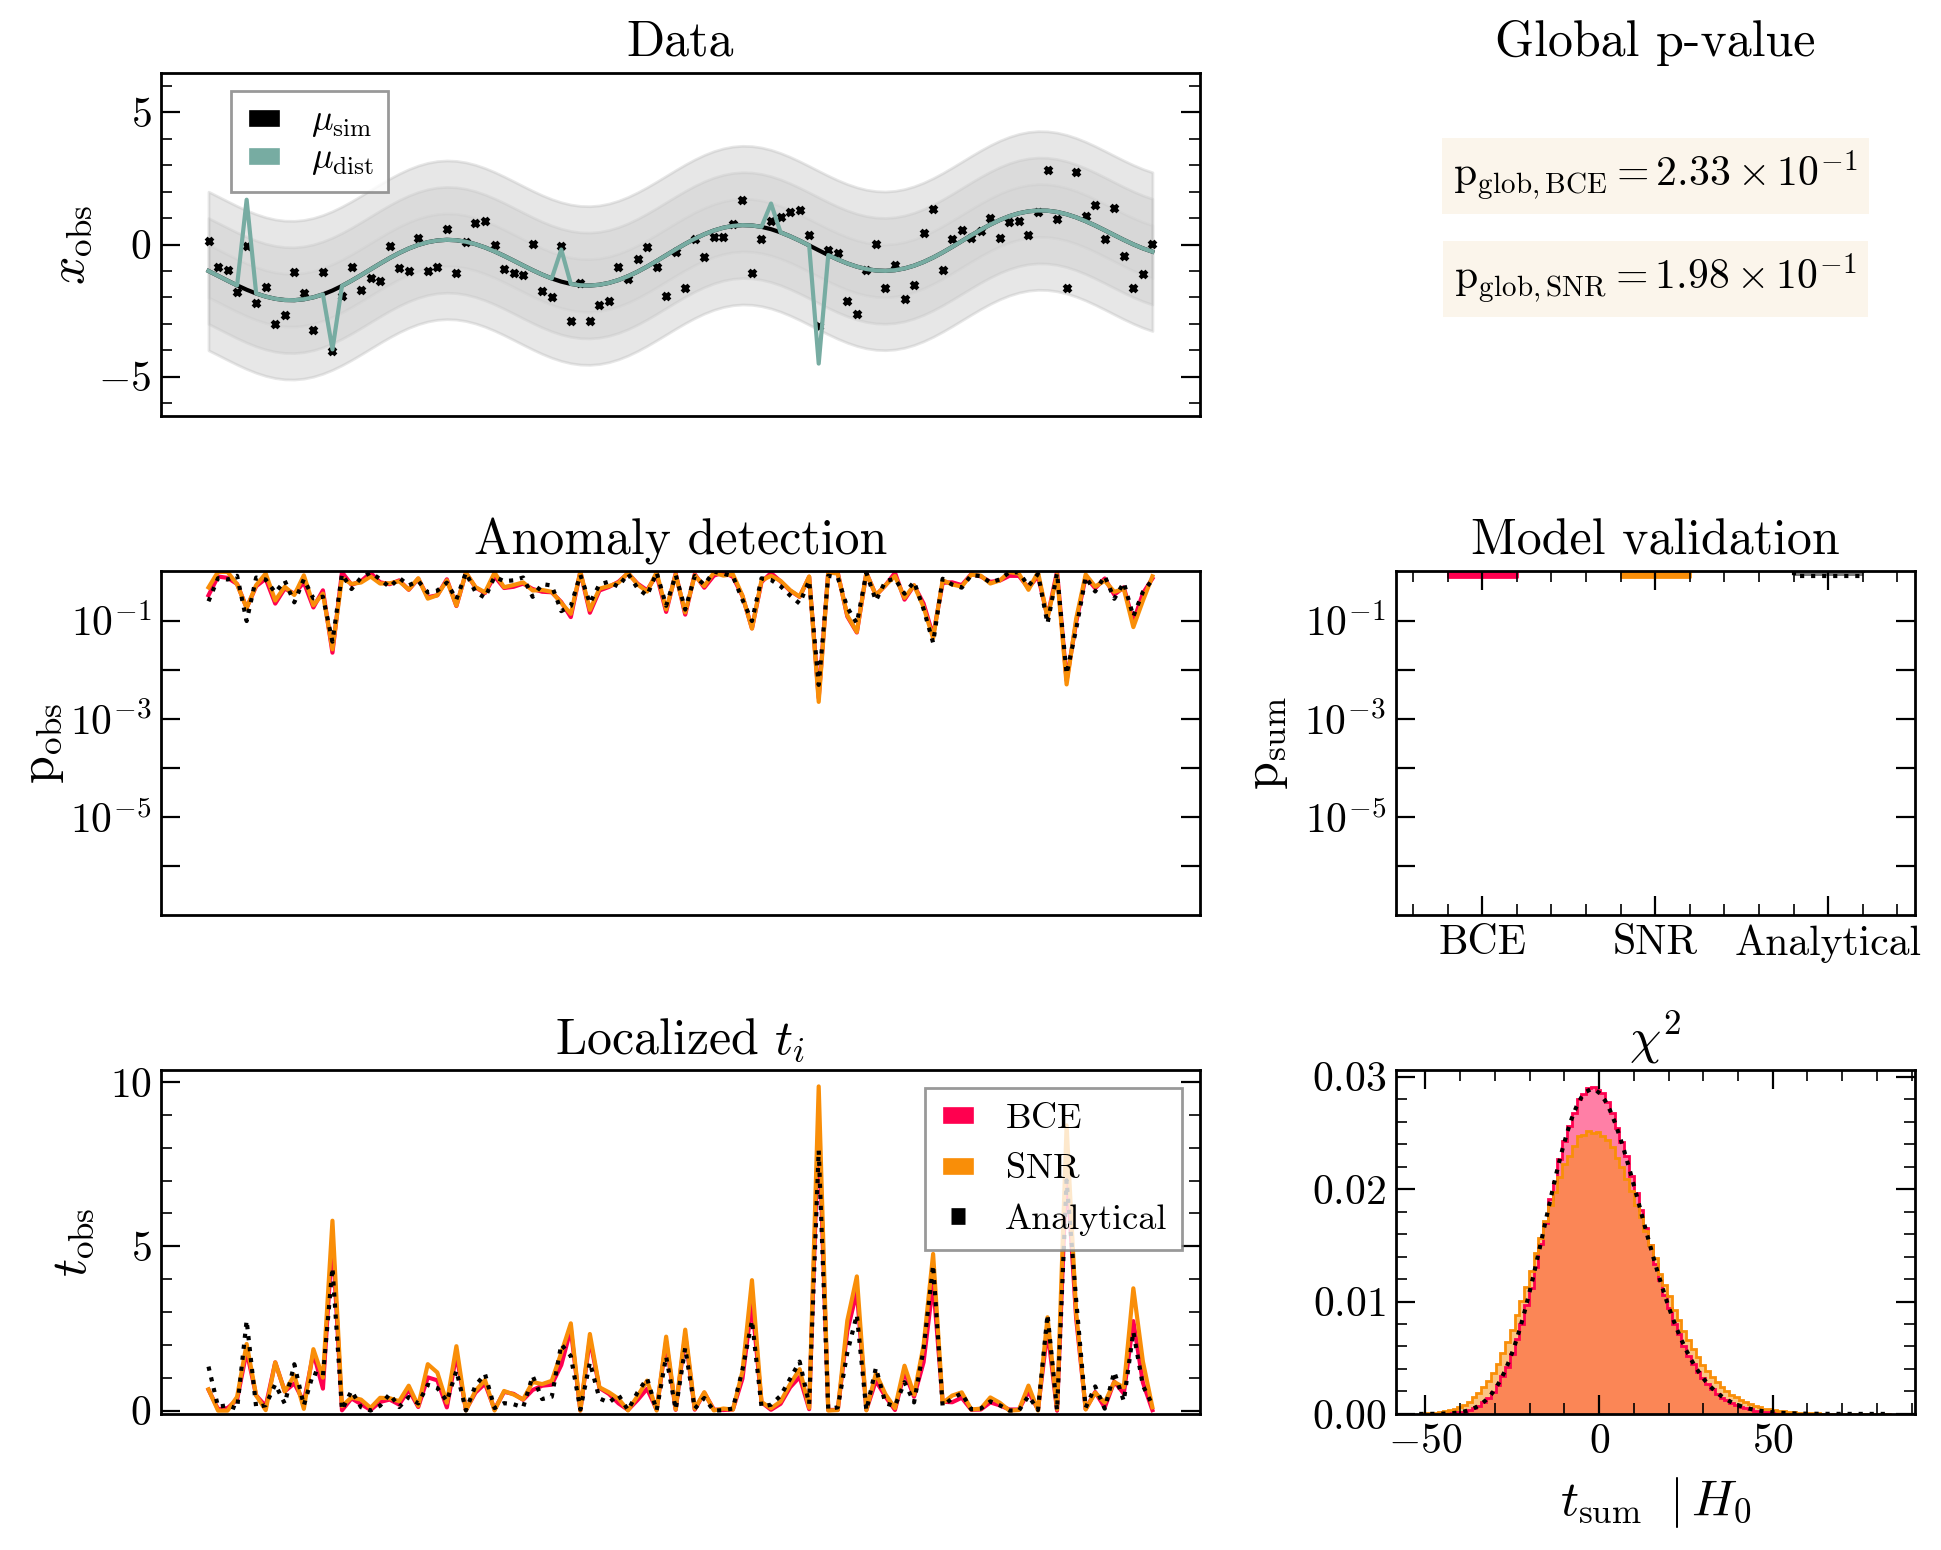

In [188]:
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=True, bounds=bounds, fraction=0.05, dtype=torch.float32) 
obs = simulator1.sample(1) 
    
ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE = analyse_obs_BCE(obs)
epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon = analyse_obs_epsilon(obs)

plot_together(
    obs, 
    ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE,
    snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon
    )

plt.savefig("figs/analytical.pdf", dpi=300, transparent=True)

print(p_sum_analytical_BCE==p_sum_analytical_epsilon, p_sum_nn_BCE>p_sum_analytical_BCE,  p_sum_nn_epsilon>p_sum_analytical_epsilon)

False False False


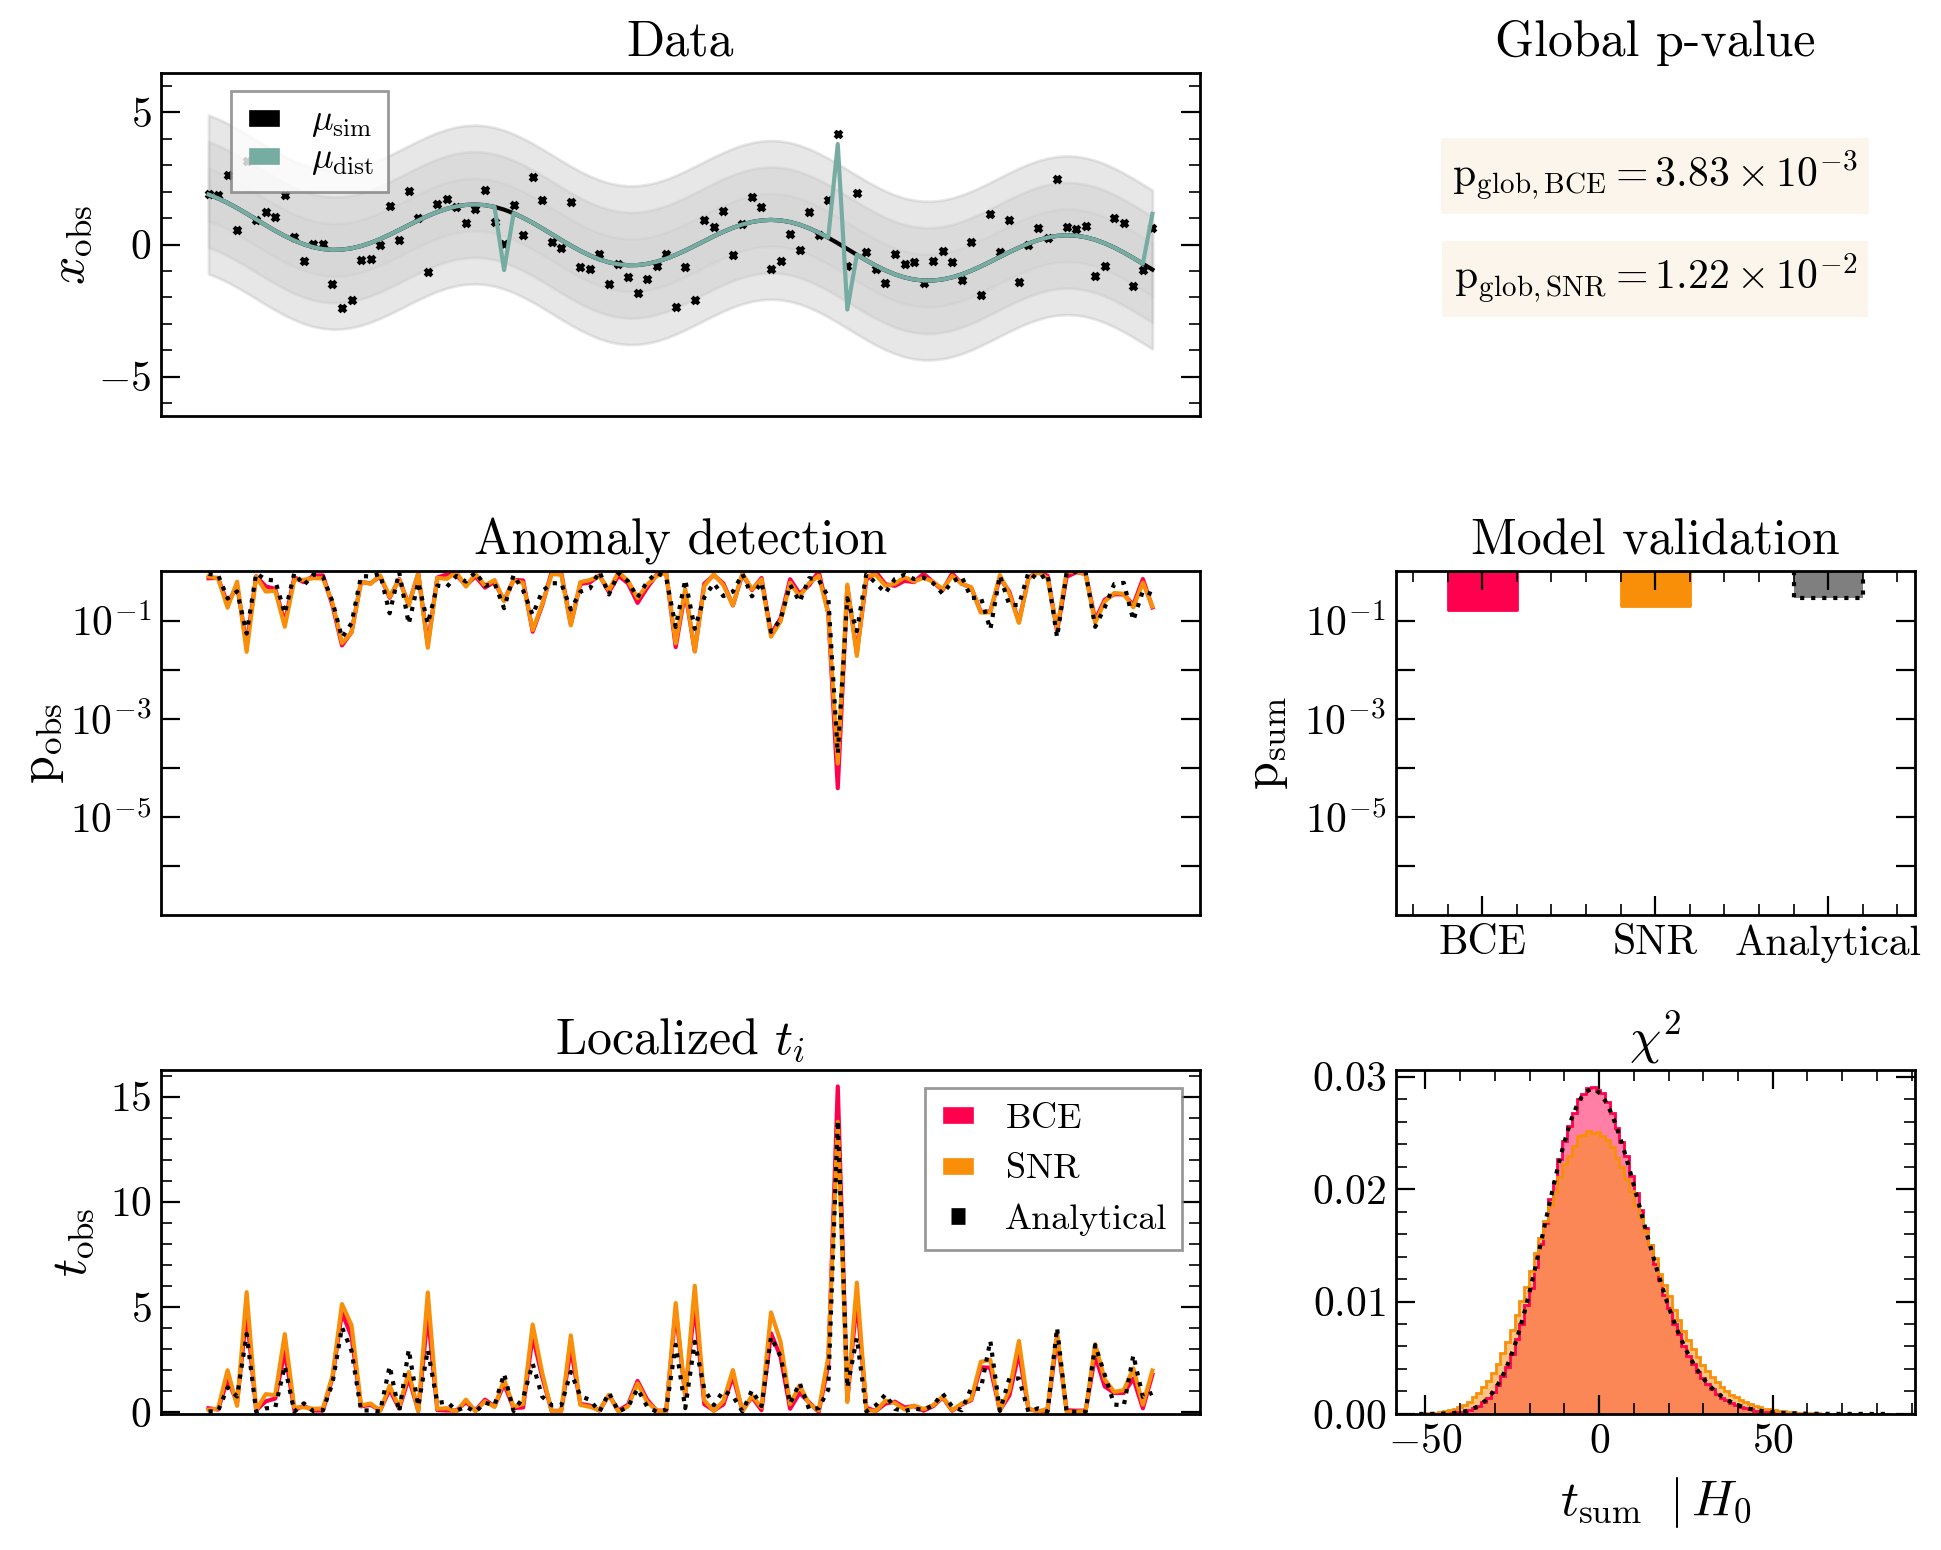

In [185]:
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=True, bounds=bounds, fraction=0.05, dtype=torch.float32) 
obs = simulator1.sample(1) 
    
ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE = analyse_obs_BCE(obs)
epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon = analyse_obs_epsilon(obs)

plot_together(
    obs, 
    ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE,
    snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon
    )

plt.savefig("figs/analytical.pdf", dpi=300, transparent=True)

print(p_sum_analytical_BCE==p_sum_analytical_epsilon, p_sum_nn_BCE>p_sum_analytical_BCE,  p_sum_nn_epsilon>p_sum_analytical_epsilon)

False True True


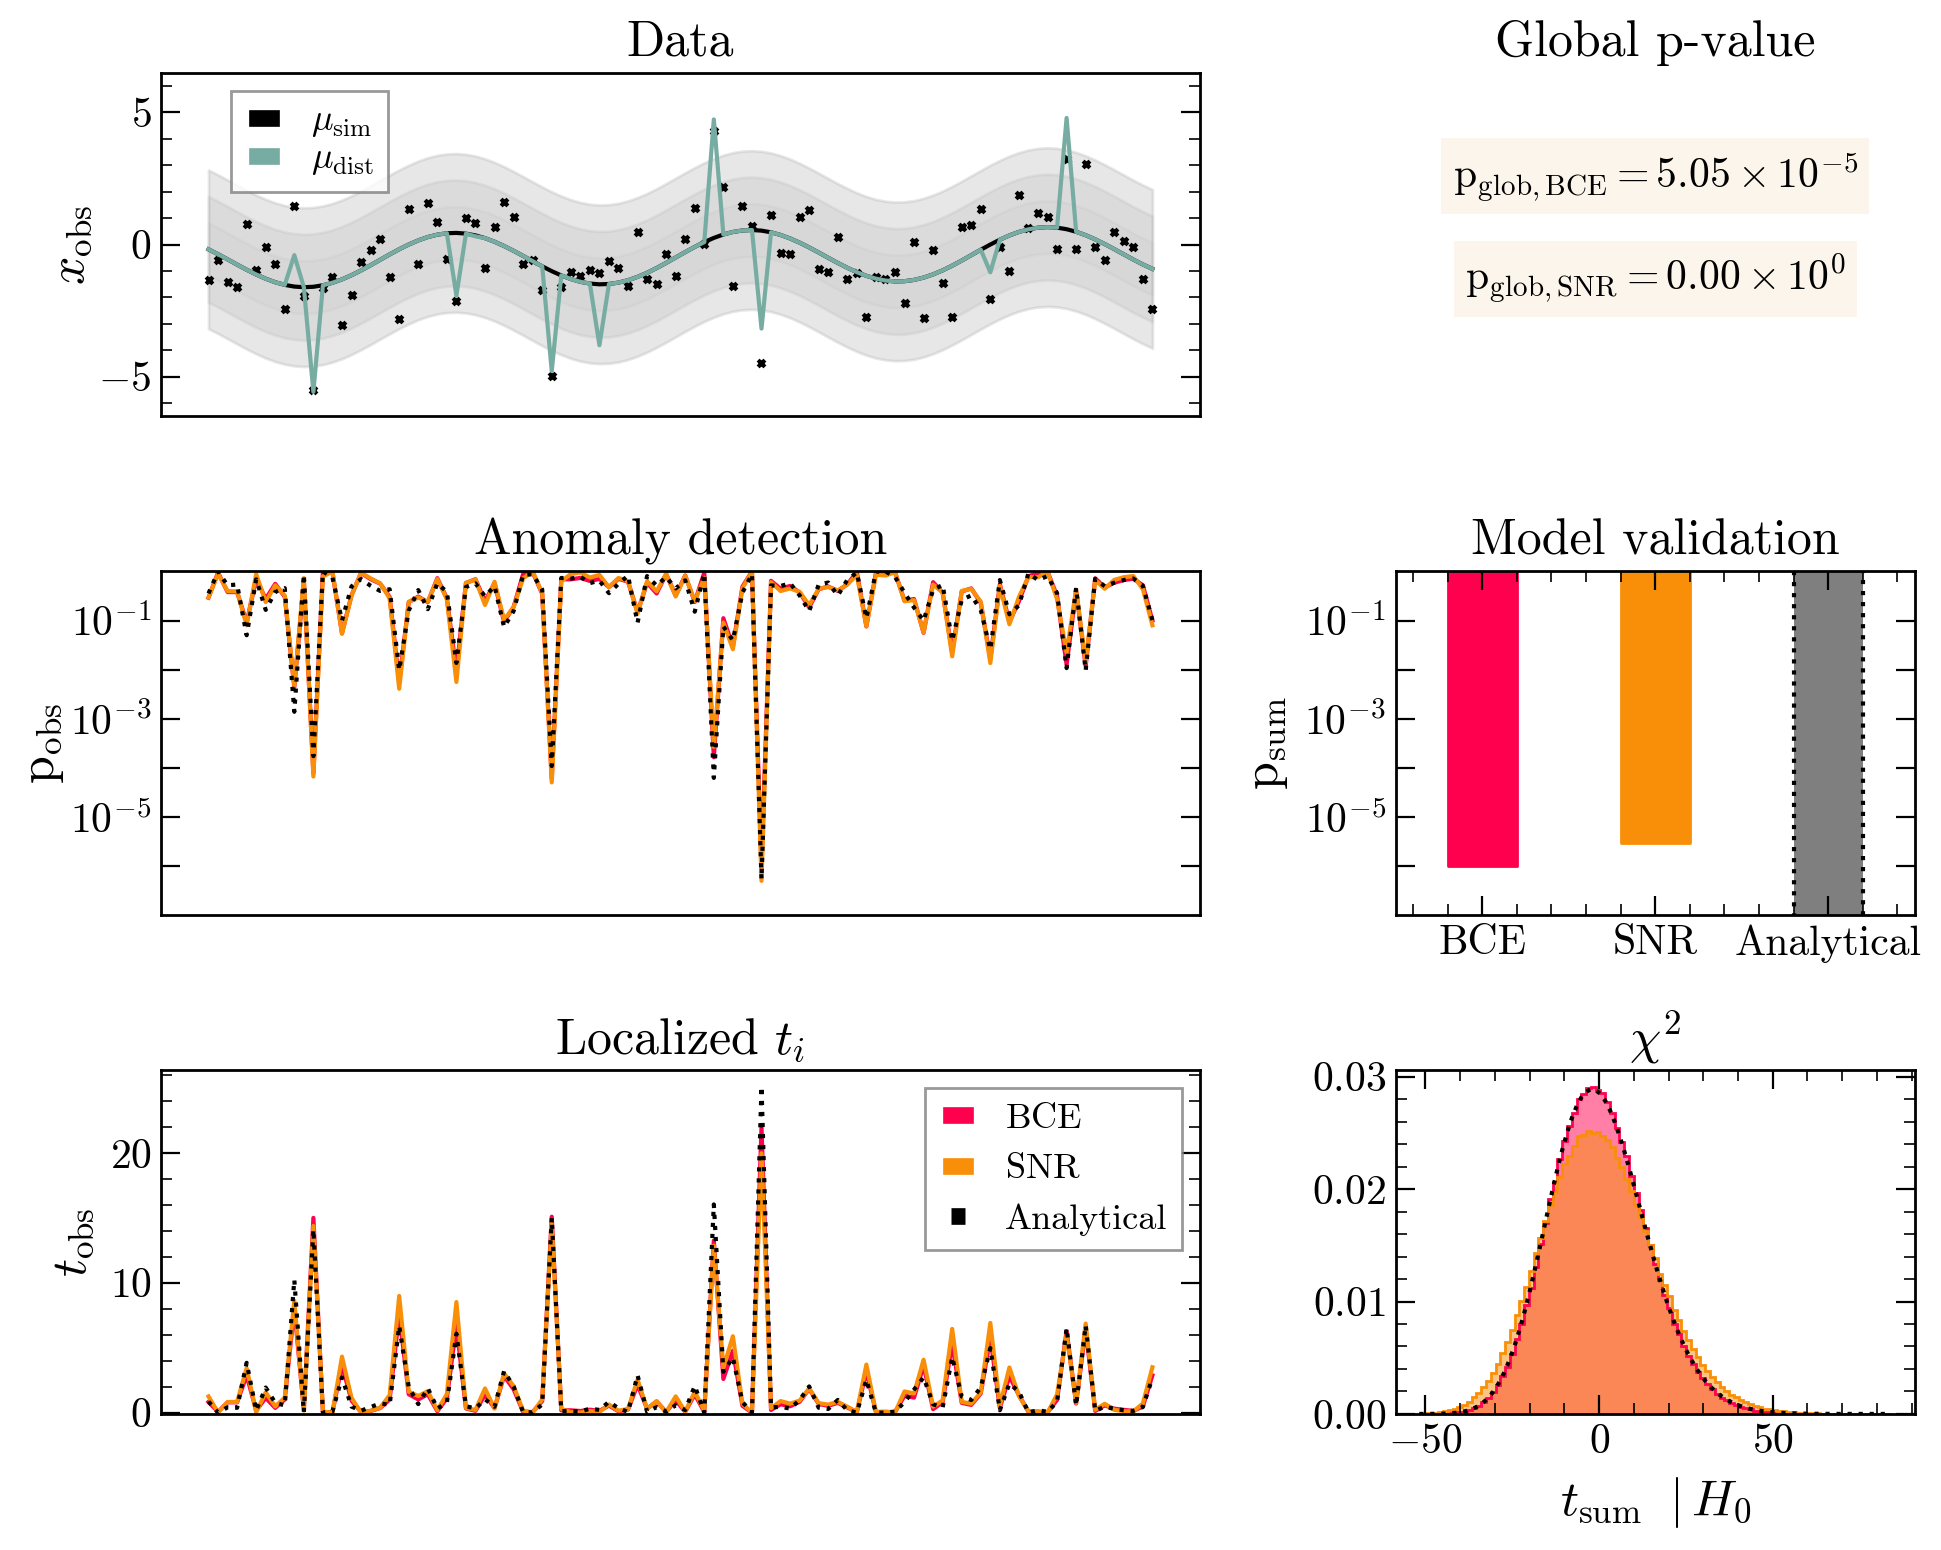

In [189]:
simulator1 = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bkg=True, bounds=bounds, fraction=0.05, dtype=torch.float32) 
obs = simulator1.sample(1) 
    
ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE = analyse_obs_BCE(obs)
epsilon_nn, epsilon_analytical, variance_nn, snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon = analyse_obs_epsilon(obs)

plot_together(
    obs, 
    ts_bin_obs, ts_bin_analytical, p_nn_BCE, p_analytical_BCE, p_sum_nn_BCE, p_sum_analytical_BCE, p_glob_all_BCE,
    snr2_nn, snr2_analytical, p_nn_epsilon, p_analytical_epsilon, p_sum_nn_epsilon, p_sum_analytical_epsilon, p_glob_all_epsilon
    )

plt.savefig("figs/analytical.pdf", dpi=300, transparent=True)

print(p_sum_analytical_BCE==p_sum_analytical_epsilon, p_sum_nn_BCE>p_sum_analytical_BCE,  p_sum_nn_epsilon>p_sum_analytical_epsilon)